# Differential expression between WT and KD within celltypes

In [1]:
here::i_am("rna_atac/differential/v2/RNA.ipynb")

source(here::here("settings.R"))
source(here::here("utils.R"))

suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(edgeR))


BPPARAM <- BiocParallel::bpparam()
BPPARAM$workers = 16

# Multi core using future - built in to seurat
plan("multicore", workers = 16)
options(future.globals.maxSize = 50 * 1024 ^ 3) # for 50 Gb RAM

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/code

Warning message:
“package ‘rtracklayer’ was built under R version 4.2.3”


In [2]:
args = list()

# Metadata
args$metadata = file.path(io$basedir, 'results/rna_atac/clustering/metadata_celltype_annotated_v2.txt.gz')

# RNA_sce
args$rna_sce = file.path(io$basedir, 'processed/rna/SingleCellExperiment.rds')

args$logFC_thr = 0.25
args$FDR_thr = 0.05

# outdir
args$outdir = file.path(io$basedir, 'results/rna_atac/differential/v2/expression/')
dir.create(args$outdir, recursive=TRUE, showWarnings =FALSE)

In [ ]:
# Load meta
meta = fread(args$metadata)[day!='D3']

#### Load Data

In [4]:
# load sce
rna.sce <- load_SingleCellExperiment(args$rna_sce, normalise = TRUE, cells = meta$cell)
colData(rna.sce) = meta %>% as.data.frame() %>% tibble::column_to_rownames('cell') %>% DataFrame()

# Convert to Seurat
seurat = as.Seurat(rna.sce)

In [5]:
# Prepare mofa umap
umap.mtx = meta[,c('cell', 'UMAP1', 'UMAP2')] %>% 
    as.data.frame(.) %>% 
    tibble::column_to_rownames('cell') %>%
    as.matrix()
seurat[["umap"]] <- CreateDimReducObject(embeddings = umap.mtx, key = "umap_", assay = DefaultAssay(seurat))

In [7]:
Idents(seurat) = seurat@meta.data$genotype

#### Seurat

In [6]:
find_DEGs = function(celltype_test, logFC_thr = args$logFC_thr, FDR_thr = args$FDR_thr, test = 'wilcox'){
    message(celltype_test)
    tmp = seurat[, meta[celltype_v2==celltype_test]$cell]
    markers_tmp = FindMarkers(tmp, ident.1 = "KO", ident.2 = "WT",
      logfc.threshold = logFC_thr, test.use = test)
    tmp = as.data.table(markers_tmp, keep.rownames=T) %>%
        setnames('rn', 'gene') %>% 
        .[,sig:=ifelse(p_val_adj <= FDR_thr, TRUE, FALSE)] %>% 
        .[,celltype:=celltype_test]
    return(tmp)
}  

# volcano plot
volcano_plot = function(dt, ntop=5, logFC_thr = args$logFC_thr, FDR_thr = args$FDR_thr, title=NULL){
    tmp = dt[,sign:=ifelse(p_val_adj < FDR_thr & abs(avg_log2FC) > logFC_thr, ifelse(avg_log2FC>0, 'pos', 'neg'), 'nonsig')] %>%
        .[order(p_val_adj)] #(-abs(avg_log2FC))]
    labels = tmp[, head(.SD, ntop),  by=sign][sign!='nonsig']
    
    negative_hits <- tmp[sign == 'pos',gene]
    positive_hits <- tmp[sign == 'neg',gene]
    all <- nrow(tmp[!is.na(sign)])
    
    p = ggplot(tmp, aes(avg_log2FC, -log10(p_val_adj), col=sign)) + 
        geom_point() +  
        scale_colour_manual(values=c('pos' = 'red', 'neg' = 'blue', 'nonsig' = 'black')) + 
        geom_vline(xintercept=c(-logFC_thr, logFC_thr),  linetype = "longdash") +
        geom_vline(xintercept=0, color='orange', linetype = "longdash") +
        geom_hline(yintercept=-log10(FDR_thr),  linetype = "longdash") + 
        ggrepel::geom_text_repel(data=labels, aes(label=gene), 
                                 color='black',
                                 size=5,
                                 box.padding = 0.5, 
                                 max.overlaps = Inf,
                                 bg.color='white', 
                                 bg.r = 0.1) + 
        annotate("text", x=0, y=ylim*1.1, size=6, label=sprintf("(%d)", all)) +
        annotate("text", x=-xlim*0.9, y=ylim*1.15, size=6, label=sprintf("%d (-)",length(negative_hits))) +
        annotate("text", x=xlim*0.9, y=ylim*1.15, size=6, label=sprintf("%d (+)",length(positive_hits))) +
        xlim(c(-max(abs(tmp$avg_log2FC)), max(abs(tmp$avg_log2FC)))) + 
        ggtitle(title) + 
        theme_bw() + 
        theme(text = element_text(size=15, color='black'),
             axis.text = element_text(size=15, color='black'),
             legend.position = 'none',
             plot.title = element_text(hjust=0.5))

    
    return(p)
}

In [27]:
keep = unique(names(opts$celltype_v2.colors))[names(opts$celltype_v2.colors) != 'Blood_Progenitor']

In [17]:
keep

[1] "PGC"                 "Allantois"           "Allantois_Precursor"
 [4] "Mesenchyme"          "Posterior_Mes"       "Early_Mes_EOi"      
 [7] "Primitive_Streak"    "Early_Mes_EOd"       "HE_Precursor"       
[10] "HE"                  "Endothelium"

In [18]:
DEGs = mclapply(keep, find_DEGs, mc.cores=12) %>% rbindlist()

In [19]:
head(DEGs)

gene   p_val        avg_log2FC pct.1 pct.2 p_val_adj    sig  celltype
1 Limch1 6.687055e-13  0.4299026 0.722 0.443 2.158916e-08 TRUE PGC     
2 Tpm1   9.031367e-13  0.3501221 0.913 0.771 2.915777e-08 TRUE PGC     
3 Cdkn1c 9.112184e-13  0.3457578 0.835 0.603 2.941869e-08 TRUE PGC     
4 Etv2   1.141123e-12 -0.4123888 0.177 0.397 3.684115e-08 TRUE PGC     
5 Uap1l1 1.534946e-10  0.3205159 0.584 0.311 4.955574e-06 TRUE PGC     
6 Dlk1   2.000610e-10  0.3724746 0.659 0.383 6.458970e-06 TRUE PGC

In [20]:
fwrite(DEGs, sprintf('%s/DEGs_seurat.txt.gz', args$outdir))

In [23]:
# Remove haemoglobin genes because useually batch effect
DEGs = DEGs[!gene %in% c('Hba-x', 'Hba-a1', 'Hba-a2', 'Hbb-bh1') ]

In [28]:
plots = mclapply(keep, function(x){
    tmp = DEGs[celltype==x]
    p = volcano_plot(tmp, ntop=10, title=x)
    return(p)
})

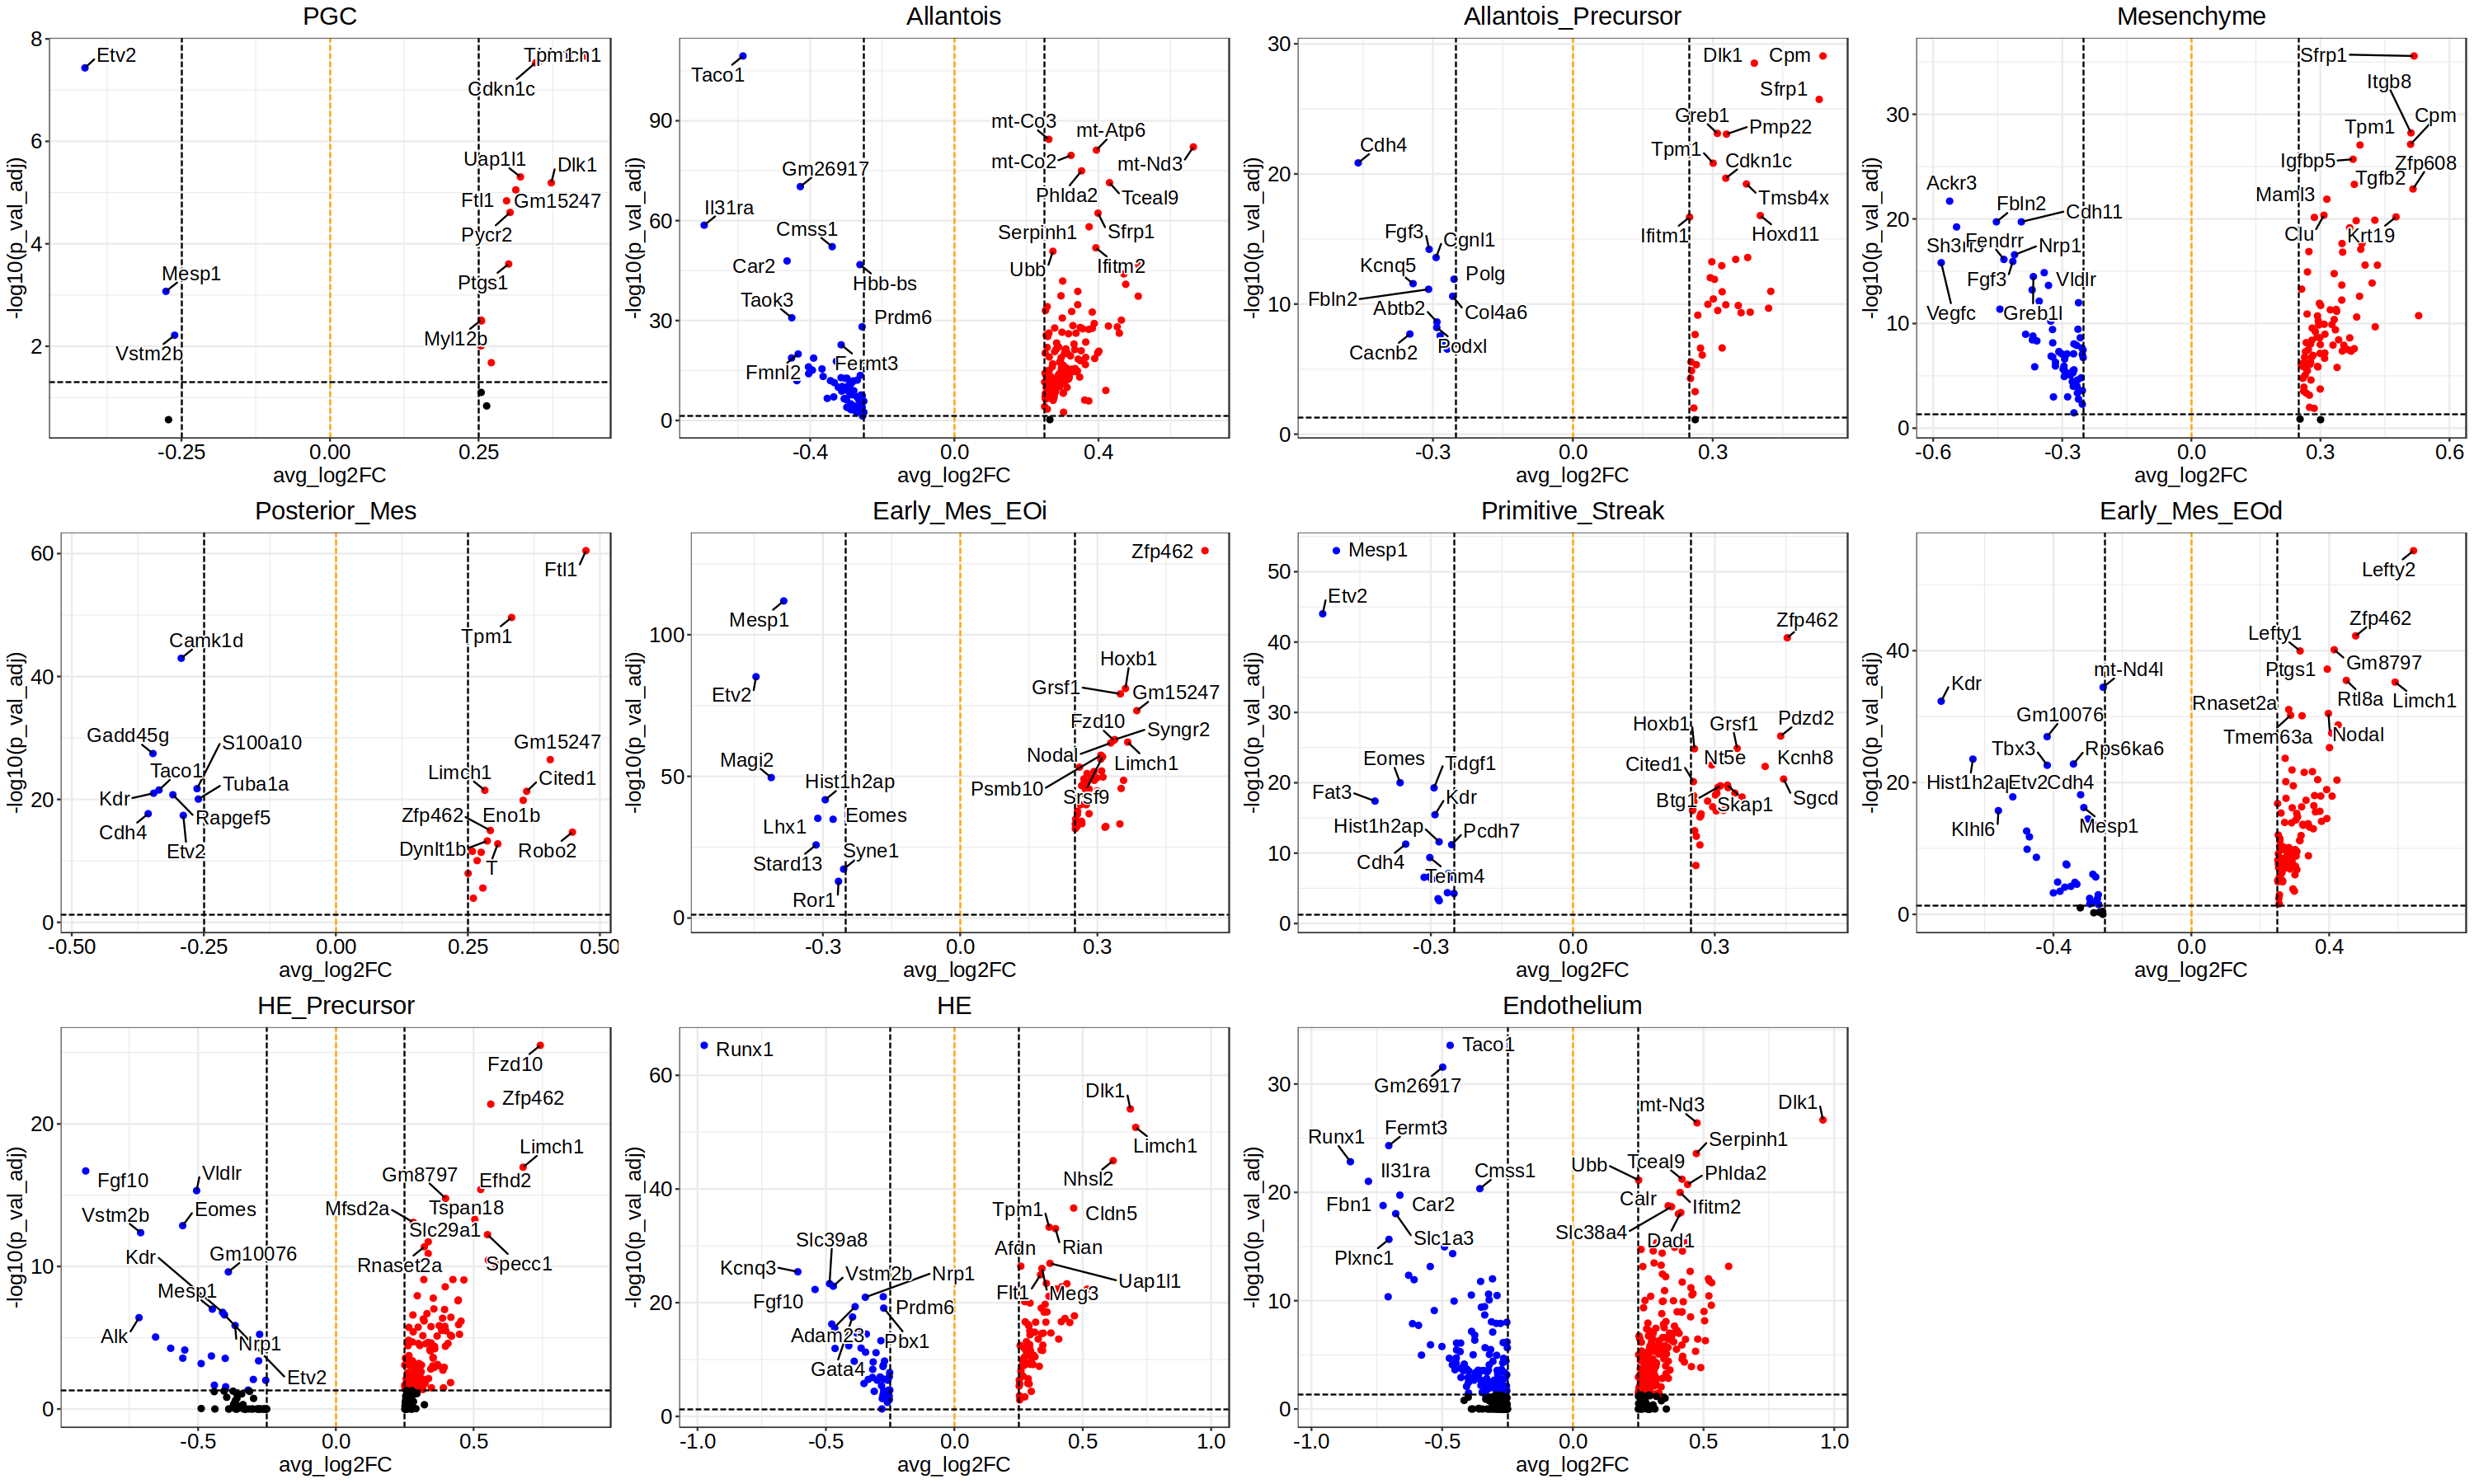

In [29]:
options(repr.plot.width=25, repr.plot.height=15)
ggarrange(plotlist=plots)

#### EdgeR

In [31]:
volcano_plot = function(dt, ntop=5, logFC_thr = args$logFC_thr, FDR_thr = args$FDR_thr, xlim=5, ylim=40, title=NULL){
    tmp = dt[,sign:=ifelse(padj_fdr < FDR_thr & abs(logFC) > logFC_thr, ifelse(logFC>0, 'pos', 'neg'), 'nonsig')] %>%
        .[order(-abs(logFC))] %>% 
        .[,logFC_plot:=ifelse(logFC<=-xlim, -xlim, ifelse(logFC>=xlim, xlim, logFC))] %>%
        .[,log10_padj_fdr:=ifelse(-log10(padj_fdr)>=ylim, ylim, -log10(padj_fdr))]
    
    labels = tmp[, head(.SD, ntop),  by=sign][sign!='nonsig']
    
    negative_hits <- tmp[sign == 'neg',gene]
    positive_hits <- tmp[sign == 'pos',gene]
    all <- nrow(tmp[!is.na(sign)])
    
    p = ggplot(tmp, aes(logFC_plot, log10_padj_fdr, col=sign, size = sign)) + 
        geom_point() + 
        scale_colour_manual(values=c('pos' = 'red', 'neg' = 'blue', 'nonsig' = 'black')) + 
        scale_size_manual(values=c('pos' = 1, 'neg' = 1, 'nonsig' = 0.2)) + 
        geom_vline(xintercept=c(-logFC_thr, logFC_thr),  linetype = "longdash") +
        geom_segment(aes(x=0, xend=0, y=0, yend=ylim*1.05), color="orange", linewidth=0.5) +
        geom_hline(yintercept=-log10(FDR_thr),  linetype = "longdash") + 
        ggrepel::geom_text_repel(data=labels, aes(label=gene), 
                                 color='black',
                                 size=5,
                                 box.padding = 0.5, 
                                 max.overlaps = Inf,
                                 bg.color='white', 
                                 bg.r = 0.1) + 
        scale_x_continuous(limits=c(-xlim*1.05,xlim*1.05), expand = c(0,0)) +
        scale_y_continuous(limits=c(0,ylim*1.2), expand = c(0,0)) +
        annotate("text", x=0, y=ylim*1.1, size=6, label=sprintf("(%d)", all)) +
        annotate("text", x=-xlim*0.9, y=ylim*1.15, size=6, label=sprintf("%d (-)",length(negative_hits))) +
        annotate("text", x=xlim*0.9, y=ylim*1.15, size=6, label=sprintf("%d (+)",length(positive_hits))) +
        #xlim(c(-max(abs(tmp$logFC)), max(abs(tmp$logFC)))) + 
        ggtitle(title) + 
        theme_bw() + 
        theme(text = element_text(size=15, color='black'),
             axis.text = element_text(size=15, color='black'),
             legend.position = 'none',
              plot.title = element_text(hjust=0.5))
    
    return(p)
}

In [40]:
cell_metadata.dt = meta[day != 'D3']
cell_metadata.dt = cell_metadata.dt[,group:=paste0(celltype_v2, '.', genotype)]

args$min_cells = 25
args$fraction_cells_per_replicate = 0.4
args$nrep = 5
args$min_CDR = 0.30

# Define groups
opts$groups <- c(args$groupA,args$groupB)

In [41]:
table(cell_metadata.dt$group)


Allantois_Precursor.KO Allantois_Precursor.WT           Allantois.KO 
                  1389                    399                   1446 
          Allantois.WT    Blood_Progenitor.KO    Blood_Progenitor.WT 
                   429                      1                    244 
      Early_Mes_EOd.KO       Early_Mes_EOd.WT       Early_Mes_EOi.KO 
                   258                   5472                   3513 
      Early_Mes_EOi.WT         Endothelium.KO         Endothelium.WT 
                  1706                    431                    206 
       HE_Precursor.KO        HE_Precursor.WT                  HE.KO 
                   103                   1290                    374 
                 HE.WT          Mesenchyme.KO          Mesenchyme.WT 
                  1734                    316                   1675 
                PGC.KO                 PGC.WT       Posterior_Mes.KO 
                   334                    350                   2864 
      Posterior_Mes

In [1]:
25/0.4

[1] 62.5

In [43]:
##################################
## Create pseudobulk replicates ##
##################################

cell2replicate.dt <- lapply(unique(cell_metadata.dt$group), function(i){
  tmp <- cell_metadata.dt[group==i]
  if ((args$fraction_cells_per_replicate*nrow(tmp))<=args$min_cells) {
    return(NULL) # ncells_per_replicate <- args$min_cells
  } else {
    ncells_per_replicate <- round(args$fraction_cells_per_replicate*nrow(tmp))

    seq(1,args$nrep) %>% map(function(j) {
    tmp[sample.int(nrow(tmp),ncells_per_replicate, replace=F)] %>% 
      .[,replicate:=sprintf("%s_rep%s",i,j)] %>%
      .[,c("cell","group","replicate")] %>% 
      return
    }) %>% rbindlist %>% return
  }
}) %>% rbindlist

stats.dt <- cell2replicate.dt[,.(ncells=.N),c("group","replicate")]
print(stats.dt)

                group             replicate ncells
  1: Early_Mes_EOd.WT Early_Mes_EOd.WT_rep1   2189
  2: Early_Mes_EOd.WT Early_Mes_EOd.WT_rep2   2189
  3: Early_Mes_EOd.WT Early_Mes_EOd.WT_rep3   2189
  4: Early_Mes_EOd.WT Early_Mes_EOd.WT_rep4   2189
  5: Early_Mes_EOd.WT Early_Mes_EOd.WT_rep5   2189
 ---                                              
111:     Allantois.KO     Allantois.KO_rep1    578
112:     Allantois.KO     Allantois.KO_rep2    578
113:     Allantois.KO     Allantois.KO_rep3    578
114:     Allantois.KO     Allantois.KO_rep4    578
115:     Allantois.KO     Allantois.KO_rep5    578


In [44]:
##################################
## Create pseudobulk replicates ##
##################################

cell2replicate.dt <- lapply(unique(cell_metadata.dt$group), function(i){
  # Select group
  tmp <- cell_metadata.dt[group==i]
  # continue only if enough cells
  if ((args$fraction_cells_per_replicate*nrow(tmp))>=args$min_cells) {
      # determine nr cells per replicate
      ncells_per_replicate <- round(args$fraction_cells_per_replicate*nrow(tmp))
      # randomly sample cells
      seq(1,args$nrep) %>% map(function(j) {
        tmp[sample.int(nrow(tmp),ncells_per_replicate, replace=F)] %>% 
          .[,replicate:=sprintf("%s_rep%s",i,j)] %>%
          .[,c("cell","group","replicate")] %>% 
          return
  }) %>% rbindlist %>% return
}}) %>% rbindlist

stats.dt <- cell2replicate.dt[,.(ncells=.N),c("group","replicate")]
print(stats.dt)

                group             replicate ncells
  1: Early_Mes_EOd.WT Early_Mes_EOd.WT_rep1   2194
  2: Early_Mes_EOd.WT Early_Mes_EOd.WT_rep2   2194
  3: Early_Mes_EOd.WT Early_Mes_EOd.WT_rep3   2194
  4: Early_Mes_EOd.WT Early_Mes_EOd.WT_rep4   2194
  5: Early_Mes_EOd.WT Early_Mes_EOd.WT_rep5   2194
 ---                                              
101:     Allantois.KO     Allantois.KO_rep1    578
102:     Allantois.KO     Allantois.KO_rep2    578
103:     Allantois.KO     Allantois.KO_rep3    578
104:     Allantois.KO     Allantois.KO_rep4    578
105:     Allantois.KO     Allantois.KO_rep5    578


In [46]:
# Create new SCE to prepare for pseudobulking
sce = as.SingleCellExperiment(seurat)[,cell2replicate.dt$cell]
sce$group_by <- cell2replicate.dt$replicate

In [50]:
################
## Pseudobulk ##
################

# sce_pseudobulk <- pseudobulk_sce_fn(
#   x = sce,
#   assay = "counts",
#   by = "group_by",
#   fun = "sum",
#   scale = FALSE
# )
sce_pseudobulk = aggregateAcrossCells(sce, id=sce$group_by, BPPARAM = BPPARAM)

assayNames(sce_pseudobulk) <- "counts"

In [51]:
###################
## Normalisation ##
###################

# log cpm
logcounts(sce_pseudobulk) <- log2(1e6*(sweep(counts(sce_pseudobulk),2,colSums(counts(sce_pseudobulk)),"/"))+1)

In [53]:
args$groupA = 'WT'
args$groupB = 'KO'
args$celltypes = unique(opts$clusters2celltypes)[unique(opts$clusters2celltypes) != 'Blood_Progenitor']
opts$groups = c(args$groupA, args$groupB)

In [54]:
sce_full = sce_pseudobulk
rm(sce_pseudobulk)

In [55]:
sce_full$celltype_v2 <- colnames(sce_full) %>% strsplit("\\.") %>% map_chr(1)
sce_full$genotype <- colnames(sce_full) %>% strsplit("\\.") %>% map_chr(2) %>% strsplit('_rep') %>% map_chr(1)
sce_full$celltype_genotype = paste0(sce_full$celltype_v2, '_', sce_full$genotype)

In [23]:
keep = names(opts$celltype_v2.colors)

In [57]:
singlecell_sce = as.SingleCellExperiment(seurat)

In [58]:
summary(colnames(singlecell_sce) == cell_metadata.dt$cell)

   Mode    TRUE 
logical   27135 

In [98]:
singlecell_sce

class: SingleCellExperiment 
dim: 32285 27135 
metadata(0):
assays(2): counts logcounts
rownames(32285): Xkr4 Gm1992 ... AC234645.1 AC149090.1
rowData names(0):
colnames(27135): 2_Eo_DEG_G9_day3_5_VC#AAACAGCCAAAGCGGC-1
  2_Eo_DEG_G9_day3_5_VC#AAACAGCCAACCTAAT-1 ...
  rv_eo_deg_day4_dtag#TTTGTGTTCATTTGTC-1
  rv_eo_deg_day4_dtag#TTTGTTGGTACTTAGG-1
colData names(29): orig.ident nCount_RNA ... celltypes_genotype ident
reducedDimNames(1): UMAP
mainExpName: RNA
altExpNames(0):

In [177]:
args$logFC_thr = 0.5

DEGs = mclapply(keep, function(ct, min.expr = 0.5, min.cdr = 0.3, logFC_thr = args$logFC_thr){
    tmp <- sprintf("%s_%s",ct,opts$groups)
    if (any(!tmp%in%unique(sce_full$celltype_genotype))) {
      warning("...")
      out <- data.table(gene=NA, logFC=NA, padj_fdr=NA, mean_groupA = NA, mean_groupB = NA, cdr_groupA=NA, cdr_groupB=NA)
    } else {
      message(ct)
      sce <- sce_full[,sce_full$celltype_v2 %in% ct]
      singlecell_sce <- rna.sce[,rna.sce$celltype_v2 %in% ct]
      singlecell_sce$celltype_genotype = sprintf("%s_%s",ct,singlecell_sce$genotype)
        # subset genotypes
        stopifnot(opts$groups%in%sce$genotype)
        sce$genotype <- factor(sce$genotype, levels=opts$groups)

        #######################################
        ## Calculate Cellular Detection Rate ##
        #######################################

        expr.dt <- data.table(
          gene = rownames(rna.sce),
          mean_groupA = rowMeans(logcounts(sce[,sce$genotype == args$groupA])) %>% round(2),
          mean_groupB = rowMeans(logcounts(sce[,sce$genotype == args$groupB])) %>% round(2),
          cdr_groupA = rowMeans(logcounts(singlecell_sce[,singlecell_sce$genotype == args$groupA])>0) %>% round(2),
          cdr_groupB = rowMeans(logcounts(singlecell_sce[,singlecell_sce$genotype == args$groupB])>0) %>% round(2)
        )

        #######################
        ## Feature selection ##
        #######################
        # filter genes
        genes.to.use <- expr.dt[mean_groupA>=min.expr | mean_groupB>=min.expr,][cdr_groupA>=min.cdr | cdr_groupB>=min.cdr,gene]
        genes.to.use = genes.to.use[!genes.to.use %in% genes.to.use[grep("*Rik|^Gm|^Rps|^Rpl|^Olfr", genes.to.use)]]

        ################################################
        ## Differential expression testing with edgeR ##
        ################################################

        # Convert SCE to DGEList
        sce_edger <- scran::convertTo(sce[genes.to.use,], type="edgeR")
        
        # Calculate Normalisation Factors
        sce_edger <- calcNormFactors(sce_edger)
        
        # Define design matrix (with intercept)
        design <- model.matrix(~sce$genotype)

        # Estimate dispersions
        sce_edger  <- estimateDisp(sce_edger,design)

        # Fit GLM
        fit <- glmQLFit(sce_edger,design)

        # Likelihood ratio test
        lrt <- glmQLFTest(fit)
        
        # Testing above logFC threshold
        #lrt = glmTreat(fit, lfc=logFC_thr)

        # Construct output data.frame
        out <- topTags(lrt, n=nrow(lrt))$table %>% as.data.table(keep.rownames=T) %>%
          setnames(c("gene","logFC","logCPM","LR","p.value","padj_fdr")) %>%
          .[,c("logCPM","LR","p.value"):=NULL] %>%
          .[,c("padj_fdr","logFC"):=list(signif(padj_fdr,digits=3), round(logFC,3))] %>%
          merge(expr.dt, by="gene", all.y=TRUE) %>%
          setorder(padj_fdr, na.last=T)
    }
    out = out %>% .[,celltype:=ct]
    return(out)
}, mc.cores=8) %>% rbindlist(., fill=TRUE)

In [178]:
fwrite(DEGs, sprintf('%s/DEGs_edgeR_pb.txt.gz', args$outdir))

In [ ]:
DEGs = fread(sprintf('%s/DEGs_edgeR_pb.txt.gz', args$outdir))

In [ ]:
DEGs = DEGs[!gene %in% c('Hba-x', 'Hba-a1', 'Hba-a2', 'Hbb-bh1') ]

In [32]:
plots = mclapply(keep, function(x){
    tmp = DEGs[celltype==x][!is.na(logFC)]
    p = volcano_plot(tmp, ntop=10, title=x, logFC_thr=0.5, xlim=2.5, ylim=25)
    return(p)
})

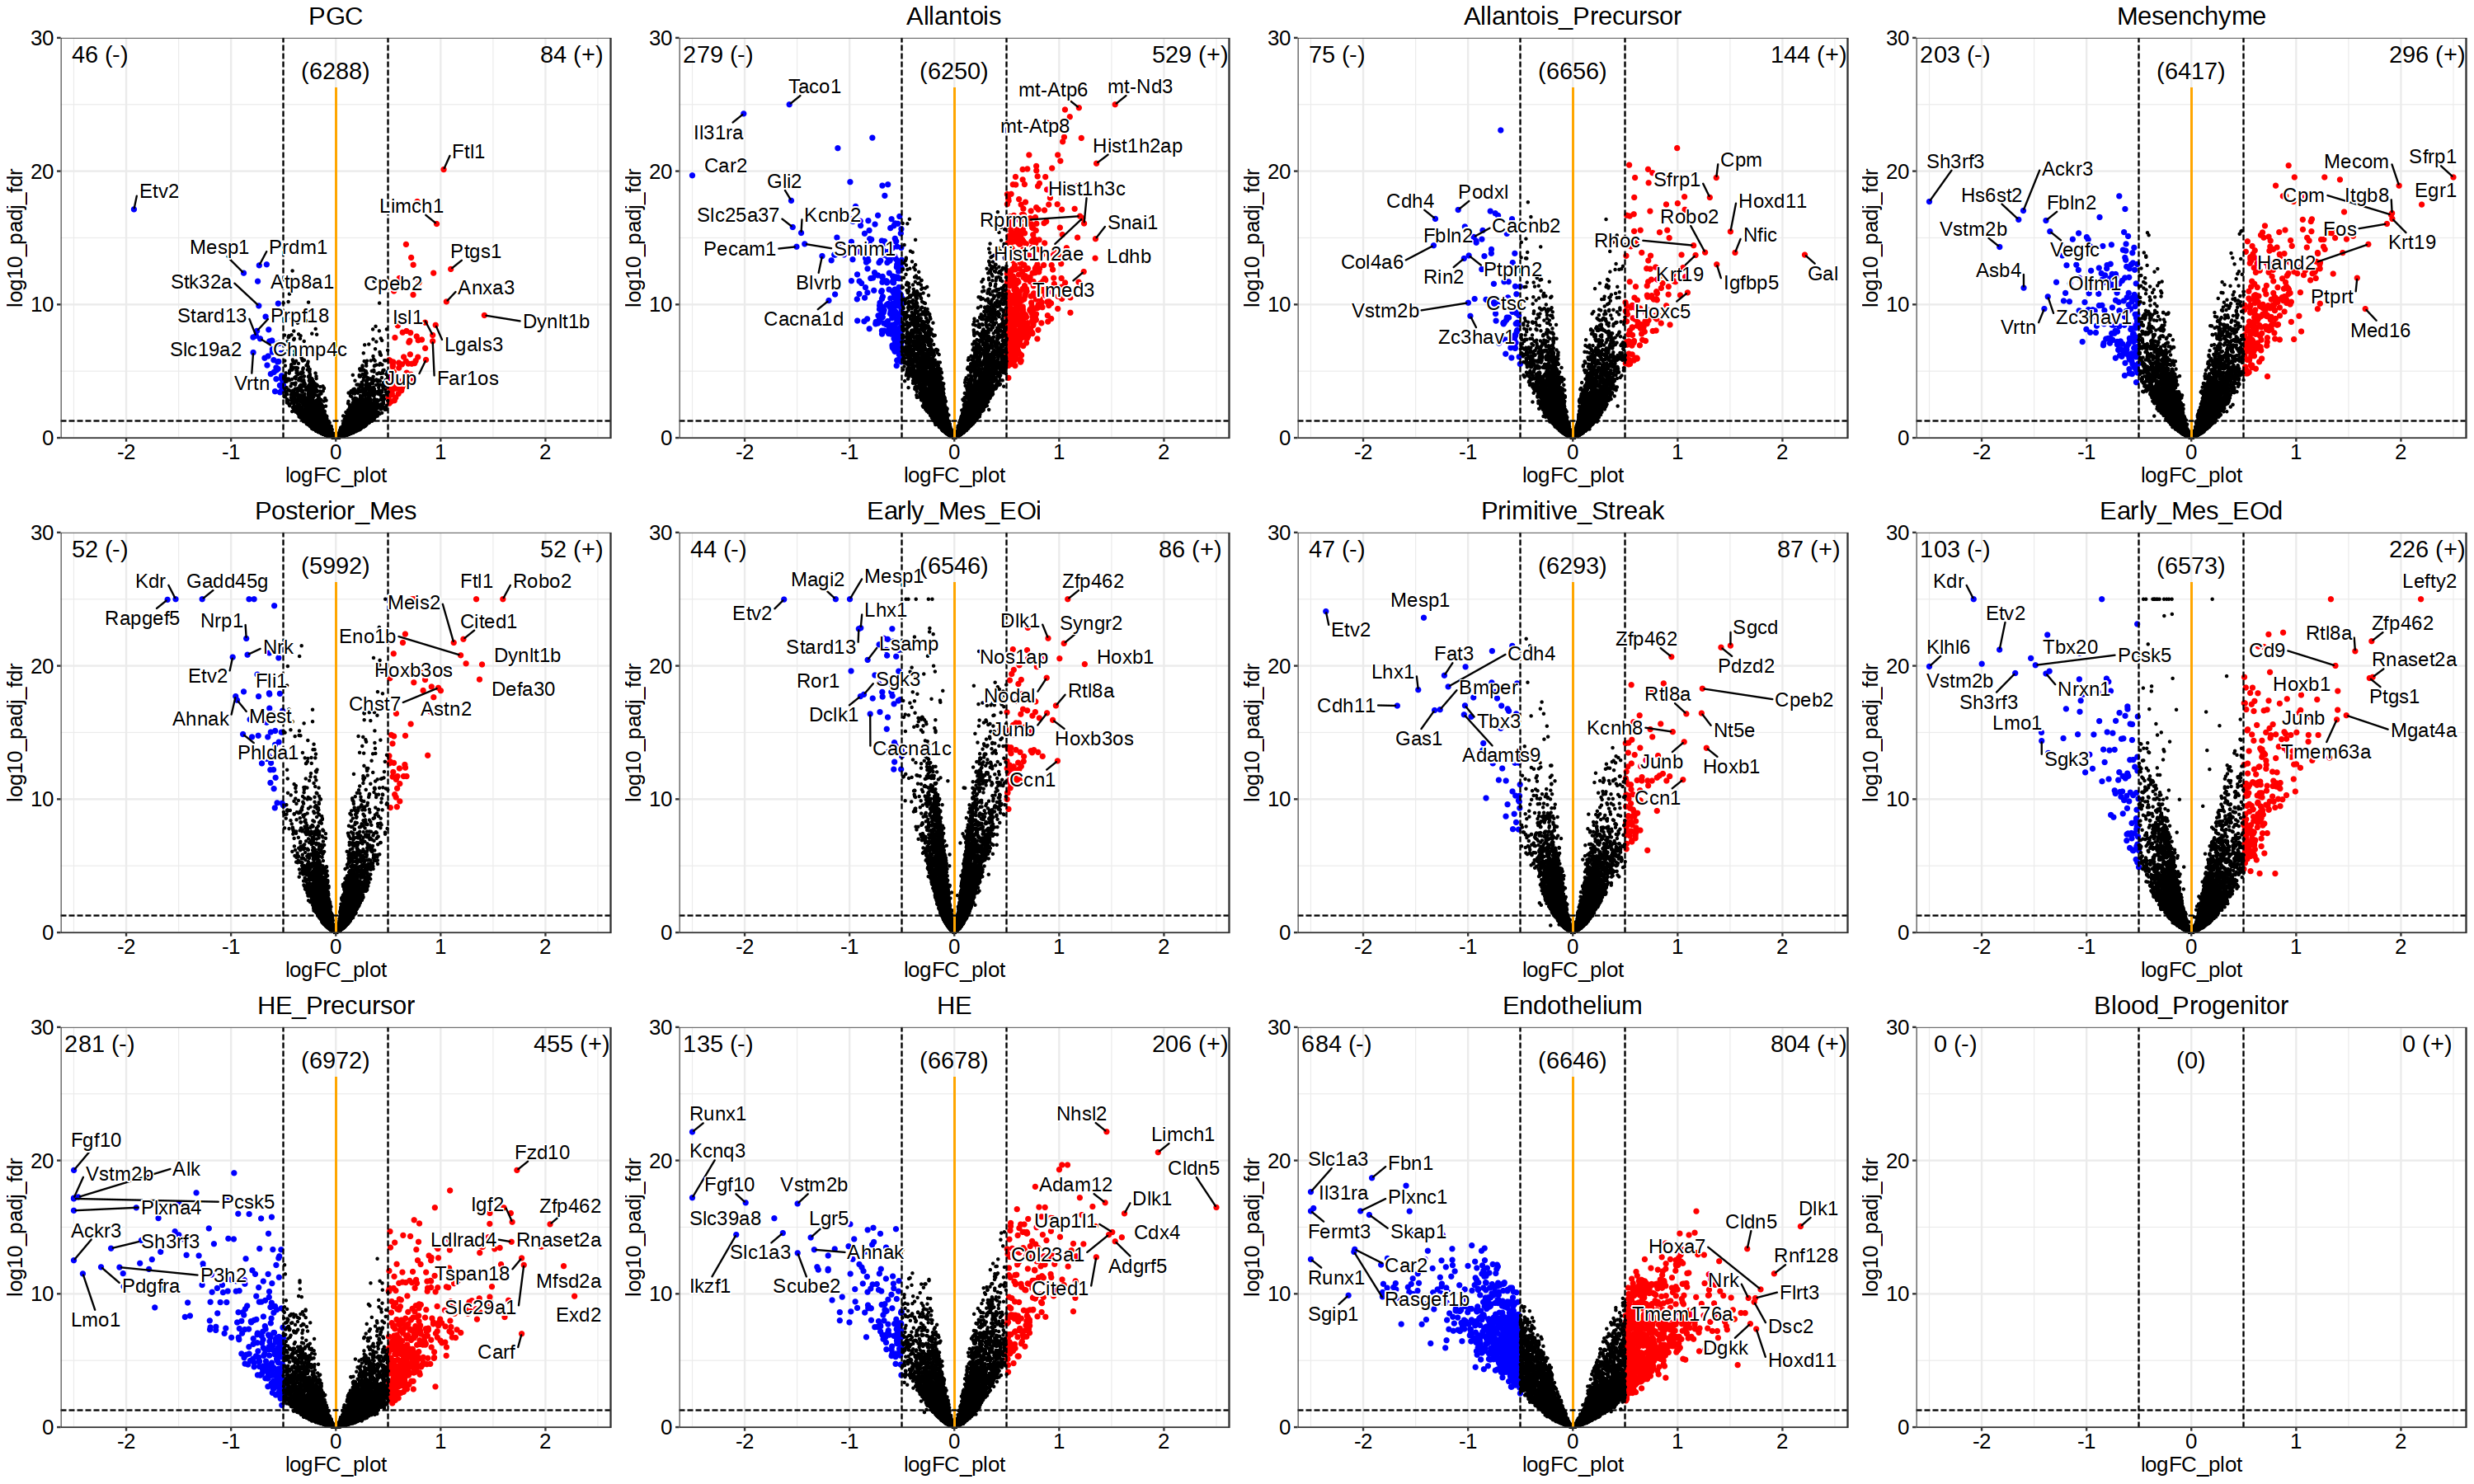

In [33]:
options(repr.plot.width=25, repr.plot.height=15)
ggarrange(plotlist=plots)

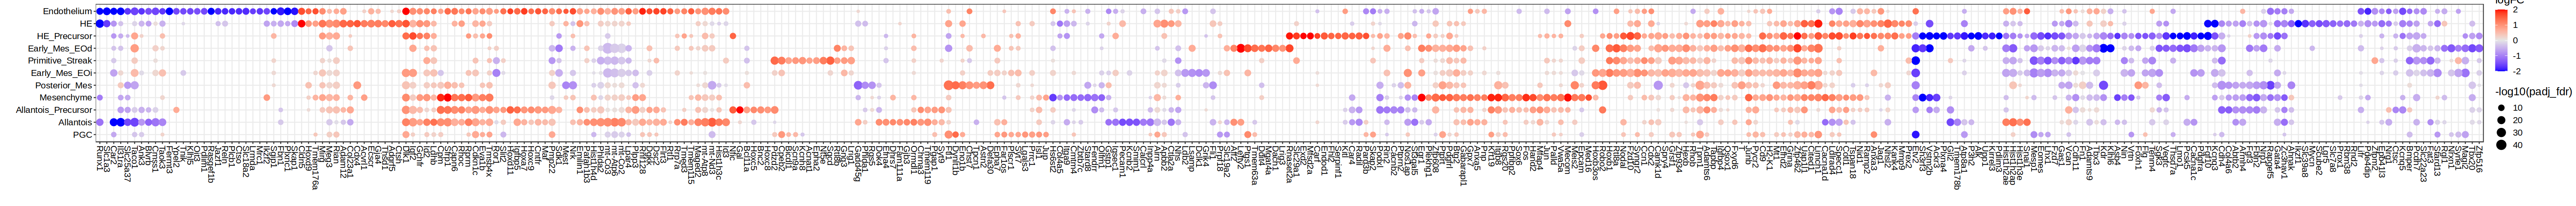

In [183]:
features = unique(DEGs[padj_fdr<0.05 & abs(logFC) > 0.75] %>% .[order(-abs(logFC)), ] %>% .[,head(.SD, 50), by=celltype] %>% .$gene)

# Turn dt in matrix
DEGs.mtx = DEGs[gene %in% features ,c('gene',  'logFC', 'celltype')] %>% dcast(., celltype ~ gene, value.var = 'logFC')
DEGs.mtx[is.na(DEGs.mtx)] = 0
DEGs.mtx = DEGs.mtx %>% as.data.frame() %>% tibble::column_to_rownames('celltype')

# Cluster genes by logFC
order = hclust(dist(t(DEGs.mtx)))

# prepare data.table for plotting
to.plot = DEGs[gene %in% features & padj_fdr < 0.05] %>%
    .[, gene := factor(gene, levels = order$labels[order$order])] %>%
    .[, celltype := factor(celltype, levels = names(opts$celltype_v2.colors))]%>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=50, repr.plot.height=4)
ggplot(to.plot, aes(gene, celltype, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC') + 
    xlab('') + ylab('') + 
    theme_bw() + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0.5),
         axis.text=element_text(size=12, color='black'),
         text=element_text(size=15))

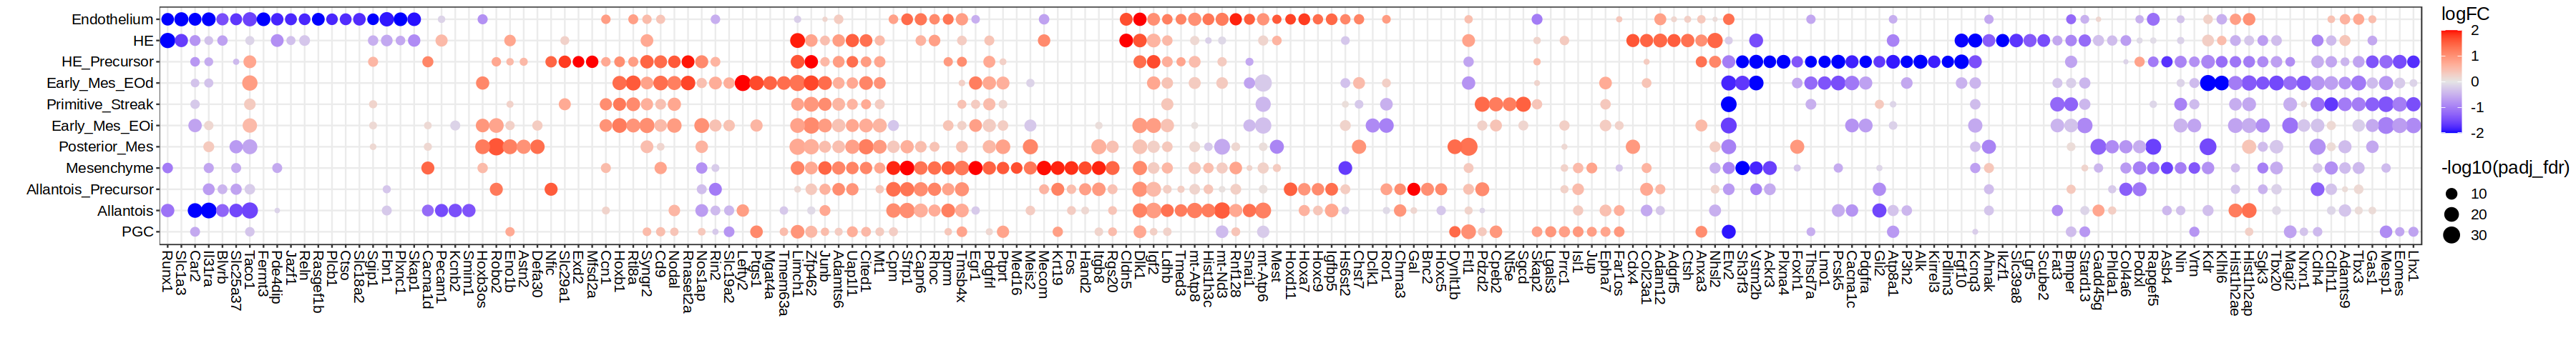

In [184]:
features = unique(DEGs[padj_fdr<0.05 & abs(logFC) > 0.75] %>% .[order(-abs(logFC)), ] %>% .[,head(.SD, 20), by=celltype] %>% .$gene)

# Turn dt in matrix
DEGs.mtx = DEGs[gene %in% features ,c('gene',  'logFC', 'celltype')] %>% dcast(., celltype ~ gene, value.var = 'logFC')
DEGs.mtx[is.na(DEGs.mtx)] = 0
DEGs.mtx = DEGs.mtx %>% as.data.frame() %>% tibble::column_to_rownames('celltype')

# Cluster genes by logFC
order = hclust(dist(t(DEGs.mtx)))

# prepare data.table for plotting
to.plot = DEGs[gene %in% features & padj_fdr < 0.05] %>%
    .[, gene := factor(gene, levels = order$labels[order$order])] %>%
    .[, celltype := factor(celltype, levels = names(opts$celltype_v2.colors))]%>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=30, repr.plot.height=4)
ggplot(to.plot, aes(gene, celltype, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC') + 
    xlab('') + ylab('') + 
    theme_bw() + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0.5),
         axis.text=element_text(size=12, color='black'),
         text=element_text(size=15))

In [ ]:
DEGs[gene %in% c('Zic2', 'Zic3')]

In [8]:
head(DEGs)

gene   logFC  padj_fdr mean_groupA mean_groupB cdr_groupA cdr_groupB celltype
1 Ftl1    1.029 7.50e-21 7.04        8.09        0.73       0.84       PGC     
2 Tpm1    0.777 1.91e-18 8.57        9.37        0.77       0.91       PGC     
3 Etv2   -1.926 7.29e-18 5.52        3.69        0.40       0.18       PGC     
4 Limch1  0.962 8.96e-17 6.73        7.71        0.44       0.72       PGC     
5 Fst     0.670 3.09e-15 8.08        8.77        0.71       0.77       PGC     
6 Cdkn1c  0.719 3.03e-14 6.98        7.72        0.60       0.84       PGC

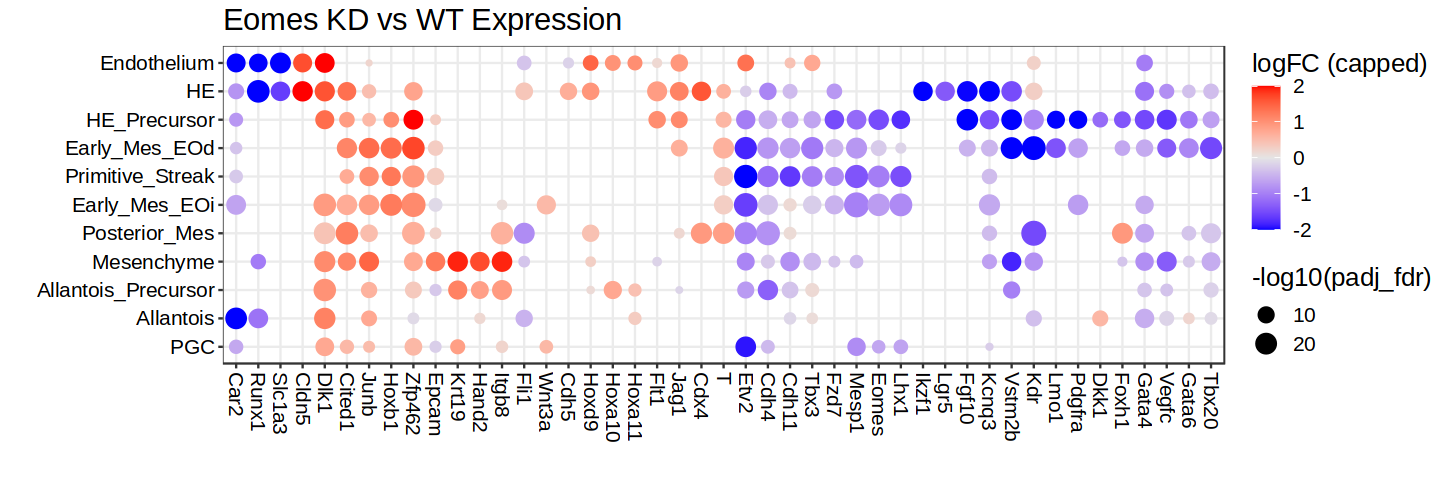

In [185]:
features = c('Kdr', 'Fgf10', 'Runx1', 'Cdh5', 'T', 'Eomes', 'Dlk1', 'Epcam', 
             'Lgr5', 'Itgb8', 'Cited1', 'Flt1', 'Jag1', 'Cdx4', 'Hoxb1', 'Junb', 'Tbx3', 'Pdgfra', 'Mesp1', 'Mesp2', 
             'Vstm2b', 'Kcnq3', 'Hoxd9', 'Hoxa10', 'Etv2',
             'Gata6', 'Gata4', 'Lhx1', 'Fli1', 'Wnt3a', 'Zfp462', 'Vegfc', 'Ikzf1', 'Flt3', 'Hoxa11', 
             'Tbx20', 'Lmo1', 'Foxh1', 'Dkk1', 'Car2', 'Slc1a3', 'Hoxb1', 'Cldn5', 'Hand2', 'Cdh4', 'Krt19','Fzd7', 'Cdh11')

# Turn dt in matrix
DEGs.mtx = DEGs[gene %in% features ,c('gene',  'logFC', 'celltype')] %>% dcast(., celltype ~ gene, value.var = 'logFC')
DEGs.mtx[is.na(DEGs.mtx)] = 0
DEGs.mtx = DEGs.mtx %>% as.data.frame() %>% tibble::column_to_rownames('celltype')

# Cluster genes by logFC
order = hclust(dist(t(DEGs.mtx)))

# prepare data.table for plotting
to.plot = DEGs[gene %in% features & padj_fdr < 0.05] %>%
    .[, gene := factor(gene, levels = order$labels[order$order])] %>%
    .[, celltype := factor(celltype, levels = names(opts$celltype_v2.colors))] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=12, repr.plot.height=4)
ggplot(to.plot, aes(gene, celltype, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') +
    ggtitle('Eomes KD vs WT Expression') + 
    theme_bw() + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0.5),
         axis.text=element_text(size=12, color='black'),
         text=element_text(size=15))

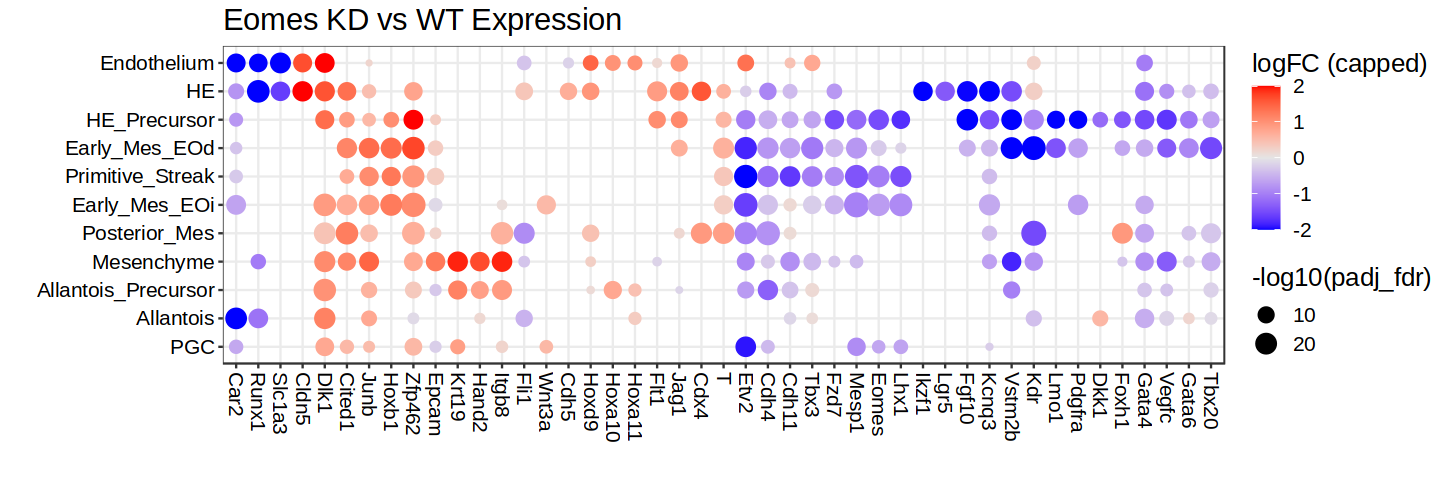

In [186]:
features = c('Kdr', 'Fgf10', 'Runx1', 'Cdh5', 'T', 'Eomes', 'Dlk1', 'Epcam', 
             'Lgr5', 'Itgb8', 'Cited1', 'Flt1', 'Jag1', 'Cdx4', 'Hoxb1', 'Junb', 'Tbx3', 'Pdgfra', 'Mesp1', 'Mesp2', 
             'Vstm2b', 'Kcnq3', 'Hoxd9', 'Hoxa10', 'Etv2',
             'Gata6', 'Gata4', 'Lhx1', 'Fli1', 'Wnt3a', 'Zfp462', 'Vegfc', 'Ikzf1', 'Flt3', 'Hoxa11', 
             'Tbx20', 'Lmo1', 'Foxh1', 'Dkk1', 'Car2', 'Slc1a3', 'Hoxb1', 'Cldn5', 'Hand2', 'Cdh4', 'Krt19','Fzd7', 'Cdh11')

# Turn dt in matrix
DEGs.mtx = DEGs[gene %in% features ,c('gene',  'logFC', 'celltype')] %>% dcast(., celltype ~ gene, value.var = 'logFC')
DEGs.mtx[is.na(DEGs.mtx)] = 0
DEGs.mtx = DEGs.mtx %>% as.data.frame() %>% tibble::column_to_rownames('celltype')

# Cluster genes by logFC
order = hclust(dist(t(DEGs.mtx)))

# prepare data.table for plotting
to.plot = DEGs[gene %in% features & padj_fdr < 0.05] %>%
    .[, gene := factor(gene, levels = order$labels[order$order])] %>%
    .[, celltype := factor(celltype, levels = names(opts$celltype_v2.colors))] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=12, repr.plot.height=4)
ggplot(to.plot, aes(gene, celltype, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') +
    ggtitle('Eomes KD vs WT Expression') + 
    theme_bw() + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0.5),
         axis.text=element_text(size=12, color='black'),
         text=element_text(size=15))

In [187]:
# Get differential genes from trajectory analysis between the two lineages
args$WT_trajectory = file.path(io$basedir, 'results/rna_atac/trajectory/v3')

patternGenes = fread(file.path(args$WT_trajectory, 'patternGenes.txt.gz'))
endGenes = fread(file.path(args$WT_trajectory, 'endGenes.txt.gz'))
genes_keep = unique(rbind(patternGenes[,c('gene', 'waldStat', 'padj', 'sig')], endGenes[,c('gene', 'waldStat', 'padj', 'sig')])[sig==TRUE][order(padj, -waldStat)]$gene)

# Get clusters from trajectory analysis
set.seed(42)
sceGAM = readRDS(file.path(args$WT_trajectory, 'sceGAM.rds'))
yhatSmooth <- tradeSeq::predictSmooth(sceGAM, gene = genes_keep, nPoints = 100, tidy = FALSE)
minmax = function(x){(x-min(x))/(max(x)-min(x))}
yhatSmooth_minmax = t(apply(yhatSmooth, 1, minmax)) 
group = kmeans(yhatSmooth_minmax, centers = 10)$cluster

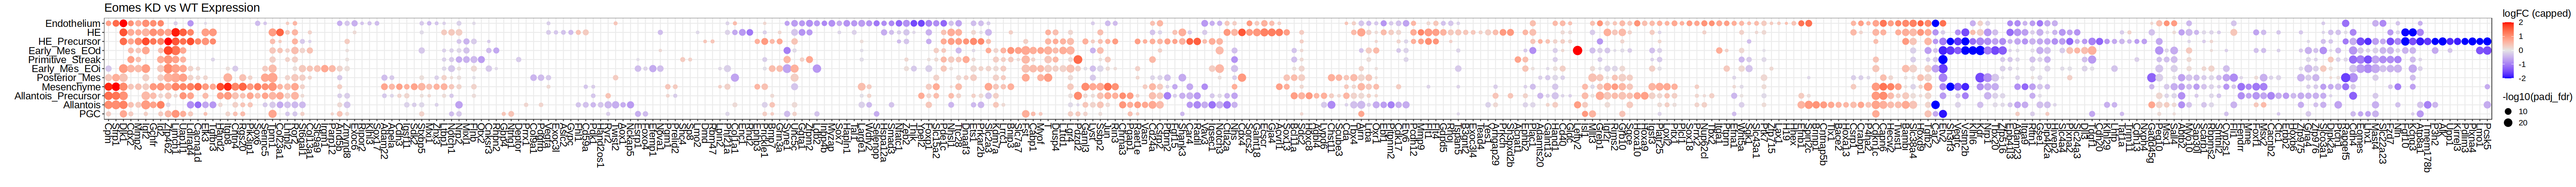

In [189]:
features = intersect(genes_keep, DEGs[padj_fdr < 0.05, gene])
# Turn dt in matrix
DEGs.mtx = DEGs[gene %in% features ,c('gene',  'logFC', 'celltype')] %>% dcast(., celltype ~ gene, value.var = 'logFC')
DEGs.mtx[is.na(DEGs.mtx)] = 0
DEGs.mtx = DEGs.mtx %>% as.data.frame() %>% tibble::column_to_rownames('celltype')

# Cluster genes by logFC
order = hclust(dist(t(DEGs.mtx)))

# prepare data.table for plotting
to.plot = DEGs[gene %in% features & padj_fdr < 0.05] %>%
    .[, gene := factor(gene, levels = order$labels[order$order])] %>%
    # .[, gene := factor(gene, levels = features)] %>%
    .[, celltype := factor(celltype, levels = names(opts$celltype_v2.colors))] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=55, repr.plot.height=4)
ggplot(to.plot, aes(gene, celltype, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') +
    ggtitle('Eomes KD vs WT Expression') + 
    theme_bw() + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0.5),
         axis.text=element_text(size=15, color='black'),
         text=element_text(size=15))

In [190]:
length(group[features])

[1] 320

In [212]:
unique(DEGs$celltype)

[1] "PGC"                 "Allantois"           "Allantois_Precursor"
 [4] "Mesenchyme"          "Posterior_Mes"       "Early_Mes_EOi"      
 [7] "Primitive_Streak"    "Early_Mes_EOd"       "HE_Precursor"       
[10] "HE"                  "Endothelium"         "Blood_Progenitor"

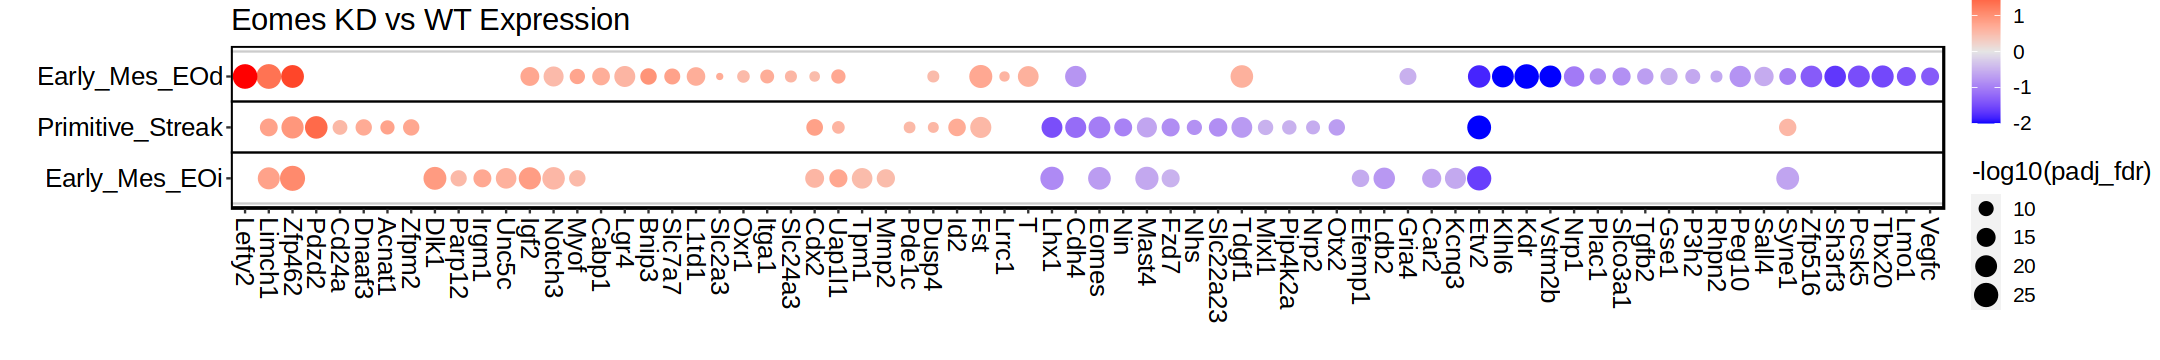

In [257]:
celltypes = c('Early_Mes_EOi','Primitive_Streak', 'Early_Mes_EOd')
features = intersect(genes_keep, DEGs[padj_fdr < 0.05 & abs(logFC) > args$logFC_thr & celltype %in% celltypes, gene])

# Turn dt in matrix
DEGs.mtx = DEGs[gene %in% features & celltype %in% celltypes, c('gene',  'logFC', 'celltype')] %>% dcast(., celltype ~ gene, value.var = 'logFC')
DEGs.mtx[is.na(DEGs.mtx)] = 0
DEGs.mtx = DEGs.mtx %>% as.data.frame() %>% tibble::column_to_rownames('celltype')

# Cluster genes by logFC
order = hclust(dist(t(DEGs.mtx)))

# prepare data.table for plotting
to.plot = DEGs[celltype %in% celltypes & gene %in% features & padj_fdr < 0.05] %>%
     .[abs(logFC) > args$logFC_thr] %>% 
    .[, gene := factor(gene, levels = order$labels[order$order])] %>%
   # .[, gene := factor(gene, levels = names(group[unique(gene)]))] %>%
    # .[, gene := factor(gene, levels = features)] %>%
    .[, celltype := factor(celltype, levels = celltypes)] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=18, repr.plot.height=3)
ggplot(to.plot, aes(gene, celltype, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') +
    geom_hline(yintercept=seq(.5, 20, 1), alpha=0.2) + 
    geom_hline(yintercept=c(1.5, 2.5), alpha=1) + 
    ggtitle('Eomes KD vs WT Expression') + 
    # facet_grid(~group, scales = 'free', space = 'free_x') + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0.5),
         axis.text=element_text(size=15, color='black'),
         text=element_text(size=15),
             panel.border = element_rect(color='black', linewidth=1, fill = NA),
             panel.background = element_blank(),
                      axis.line = element_blank(),
          strip.background = element_blank()
)

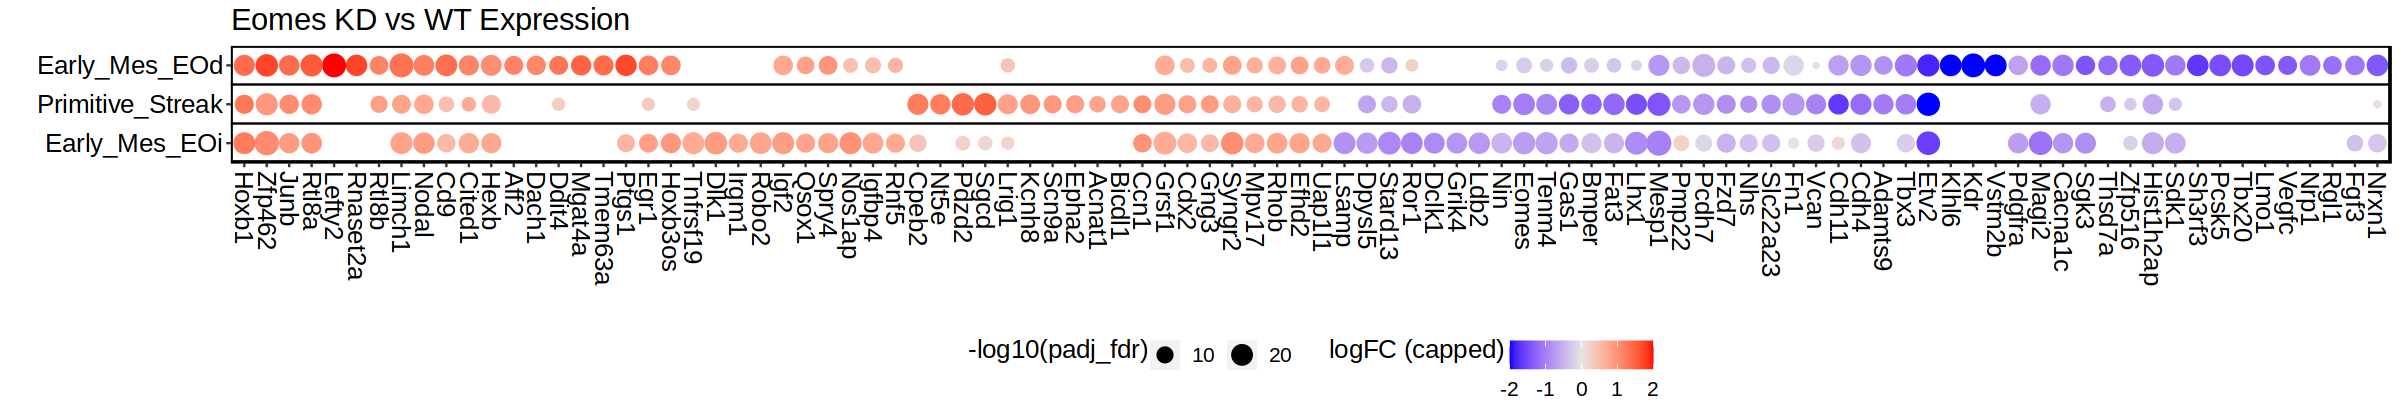

In [337]:
celltypes = c('Early_Mes_EOi','Primitive_Streak', 'Early_Mes_EOd')
features = DEGs[padj_fdr < 0.05 & celltype %in% celltypes, ] %>% 
    .[order(-abs(logFC)),] %>% 
    .[,head(.SD, 40), by=celltype] %>% .$gene

# Turn dt in matrix
DEGs.mtx = DEGs[gene %in% features & celltype %in% celltypes, c('gene',  'logFC', 'celltype')] %>% dcast(., celltype ~ gene, value.var = 'logFC')
DEGs.mtx[is.na(DEGs.mtx)] = 0
DEGs.mtx = DEGs.mtx %>% as.data.frame() %>% tibble::column_to_rownames('celltype')

# Cluster genes by logFC
order = hclust(dist(t(DEGs.mtx)))

# prepare data.table for plotting
to.plot = DEGs[celltype %in% celltypes & gene %in% features & padj_fdr < 0.05] %>%
     # .[abs(logFC) > args$logFC_thr] %>% 
    .[, gene := factor(gene, levels = order$labels[order$order])] %>%
    .[, celltype := factor(celltype, levels = celltypes)] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=20, repr.plot.height=3.5)
ggplot(to.plot, aes(gene, celltype, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') +
    geom_hline(yintercept=seq(.5, 20, 1), alpha=0.2) + 
    geom_hline(yintercept=c(1.5, 2.5), alpha=1) + 
    scale_y_discrete(limits = celltypes, expand = c(0, 0.5)) + 
    ggtitle('Eomes KD vs WT Expression') + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0.5),
         axis.text=element_text(size=15, color='black'),
         text=element_text(size=15),
            panel.border = element_rect(color='black', linewidth=1, fill = NA),
            panel.background = element_blank(),
            axis.line = element_blank(),
          legend.position = 'bottom',
          legend.title = element_text(vjust=1)
)

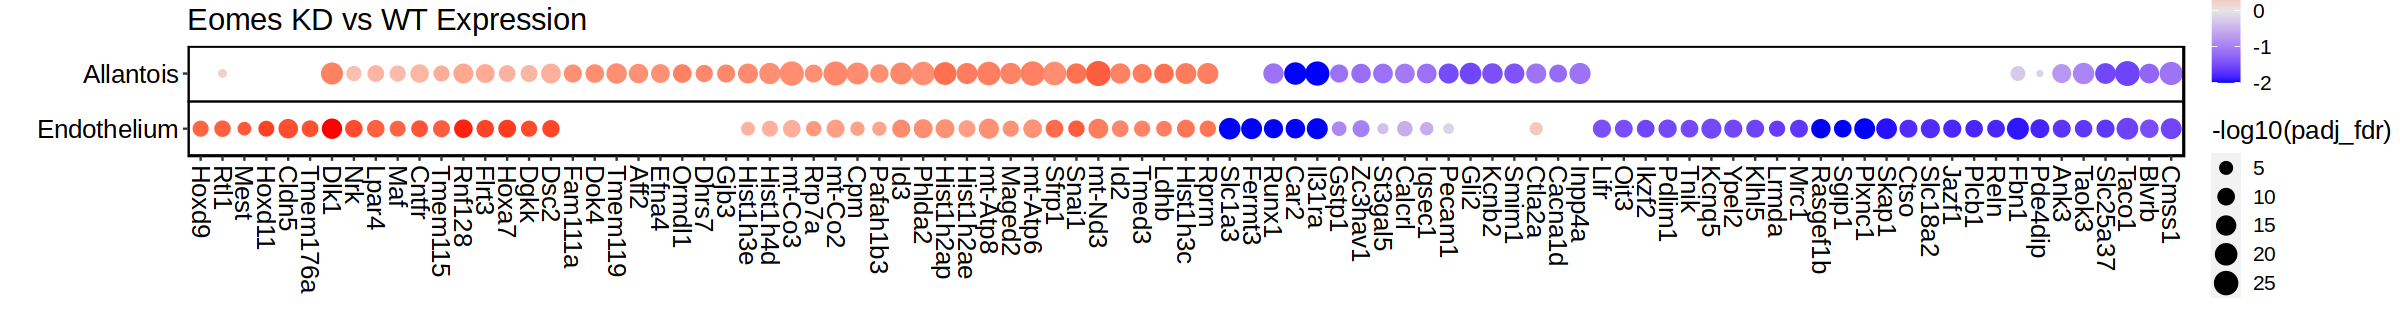

In [284]:
celltypes = c('Endothelium', 'Allantois')
features = DEGs[padj_fdr < 0.05 & celltype %in% celltypes, ] %>% 
    .[order(-abs(logFC)),] %>% 
    .[,head(.SD, 50), by=celltype] %>% .$gene

# Turn dt in matrix
DEGs.mtx = DEGs[gene %in% features & celltype %in% celltypes, c('gene',  'logFC', 'celltype')] %>% dcast(., celltype ~ gene, value.var = 'logFC')
DEGs.mtx[is.na(DEGs.mtx)] = 0
DEGs.mtx = DEGs.mtx %>% as.data.frame() %>% tibble::column_to_rownames('celltype')

# Cluster genes by logFC
order = hclust(dist(t(DEGs.mtx)))

# prepare data.table for plotting
to.plot = DEGs[celltype %in% celltypes & gene %in% features & padj_fdr < 0.05] %>%
     # .[abs(logFC) > args$logFC_thr] %>% 
    .[, gene := factor(gene, levels = order$labels[order$order])] %>%
    .[, celltype := factor(celltype, levels = celltypes)] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=20, repr.plot.height=2.75)
ggplot(to.plot, aes(gene, celltype, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') +
    geom_hline(yintercept=seq(.5, 20, 1), alpha=0.2) + 
    geom_hline(yintercept=c(1.5, 2.5), alpha=1) + 
    scale_y_discrete(limits = celltypes, expand = c(0, 0.5)) + 
    ggtitle('Eomes KD vs WT Expression') + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0.5),
         axis.text=element_text(size=15, color='black'),
         text=element_text(size=15),
            panel.border = element_rect(color='black', linewidth=1, fill = NA),
            panel.background = element_blank(),
            axis.line = element_blank()
)

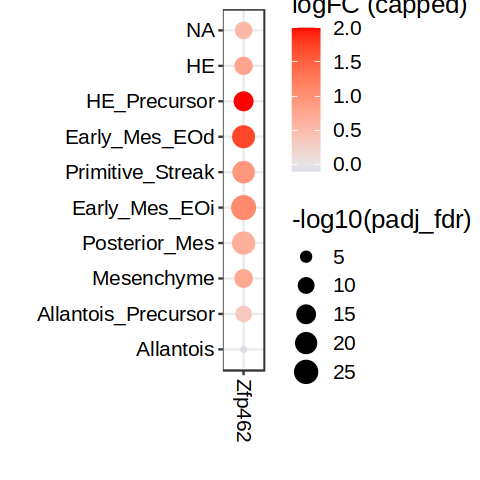

In [192]:
features = c('Zfp462')

# prepare data.table for plotting
to.plot = DEGs[gene %in% features & padj_fdr < 0.05] %>%
    .[, gene := factor(gene)] %>%
    .[, celltype := factor(celltype, levels = opts$celltype_levels2)] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=4, repr.plot.height=4)
ggplot(to.plot, aes(gene, celltype, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') +
    #ggtitle('Eomes KD vs WT Expression') + 
    theme_bw() + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0.5),
         axis.text=element_text(size=12, color='black'),
         text=element_text(size=15))

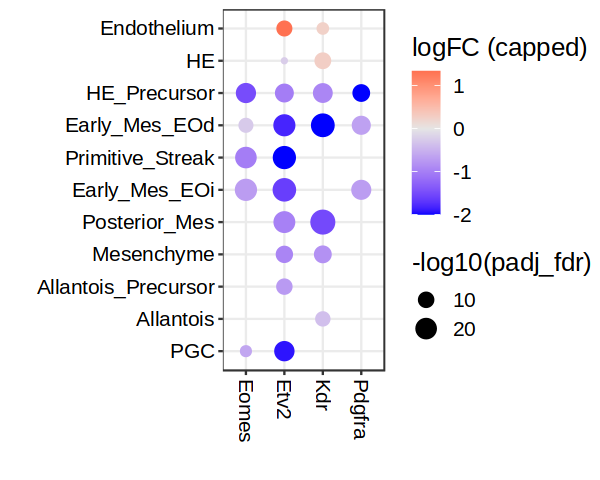

In [56]:
features = c('Eomes','Etv2', 'Kdr', 'Pdgfra')

# prepare data.table for plotting
to.plot = DEGs[gene %in% features & padj_fdr < 0.05] %>%
    .[, gene := factor(gene)] %>%
    .[, celltype := factor(celltype, levels = names(opts$celltype_v2.colors))] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=5, repr.plot.height=4)
ggplot(to.plot, aes(gene, celltype, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') +
    #ggtitle('Eomes KD vs WT Expression') + 
    theme_bw() + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0.5),
         axis.text=element_text(size=12, color='black'),
         text=element_text(size=15))

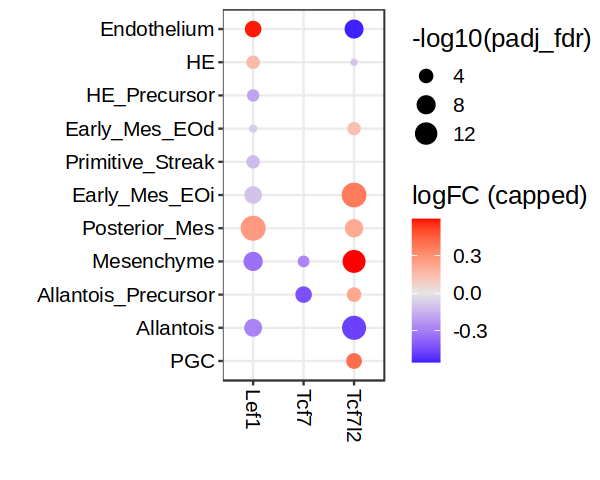

In [57]:
features = c('Lef1', 'Tcf7', 'Tcf7l2')

# prepare data.table for plotting
to.plot = DEGs[gene %in% features & padj_fdr < 0.05] %>%
    .[, gene := factor(gene)] %>%
    .[, celltype := factor(celltype, levels = names(opts$celltype_v2.colors))] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=5, repr.plot.height=4)
ggplot(to.plot, aes(gene, celltype, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') +
    #ggtitle('Eomes KD vs WT Expression') + 
    theme_bw() + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0.5),
         axis.text=element_text(size=12, color='black'),
         text=element_text(size=15))

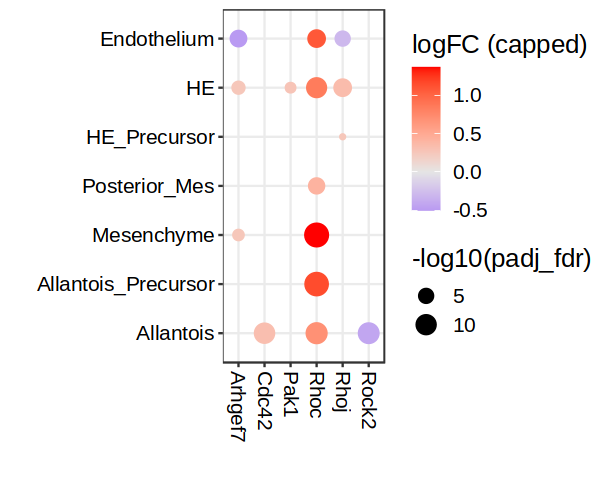

In [55]:
features = c('Rock2', 'Cdc42', 'Pak1', 'Rac2', 'Arhgef7', 'Rhoj', 'Rhoc')

# prepare data.table for plotting
to.plot = DEGs[gene %in% features & padj_fdr < 0.05 & abs(logFC) > args$logFC_thr] %>%
    .[, gene := factor(gene)] %>%
    .[, celltype := factor(celltype, levels = names(opts$celltype_v2.colors))] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=5, repr.plot.height=4)
ggplot(to.plot, aes(gene, celltype, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') +
    #ggtitle('Eomes KD vs WT Expression') + 
    theme_bw() + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0.5),
         axis.text=element_text(size=12, color='black'),
         text=element_text(size=15))

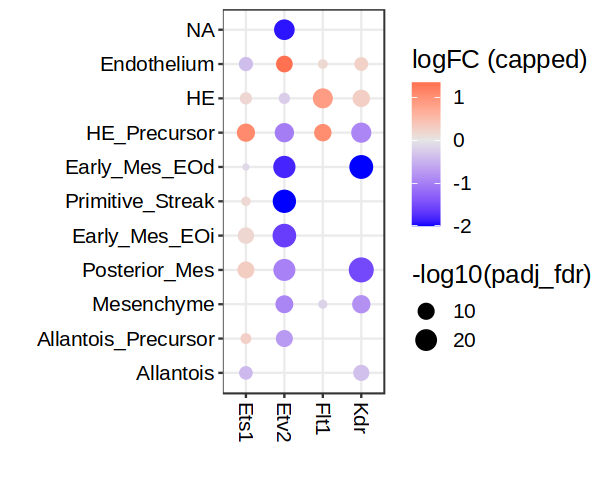

In [329]:
features = c('Vegf', 'Flt1','Kdr','Etv2', 'Ets1')

# prepare data.table for plotting
to.plot = DEGs[gene %in% features & padj_fdr < 0.05] %>%
    .[, gene := factor(gene)] %>%
    .[, celltype := factor(celltype, levels = opts$celltype_levels2)] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=5, repr.plot.height=4)
ggplot(to.plot, aes(gene, celltype, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') +
    #ggtitle('Eomes KD vs WT Expression') + 
    theme_bw() + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0.5),
         axis.text=element_text(size=12, color='black'),
         text=element_text(size=15))

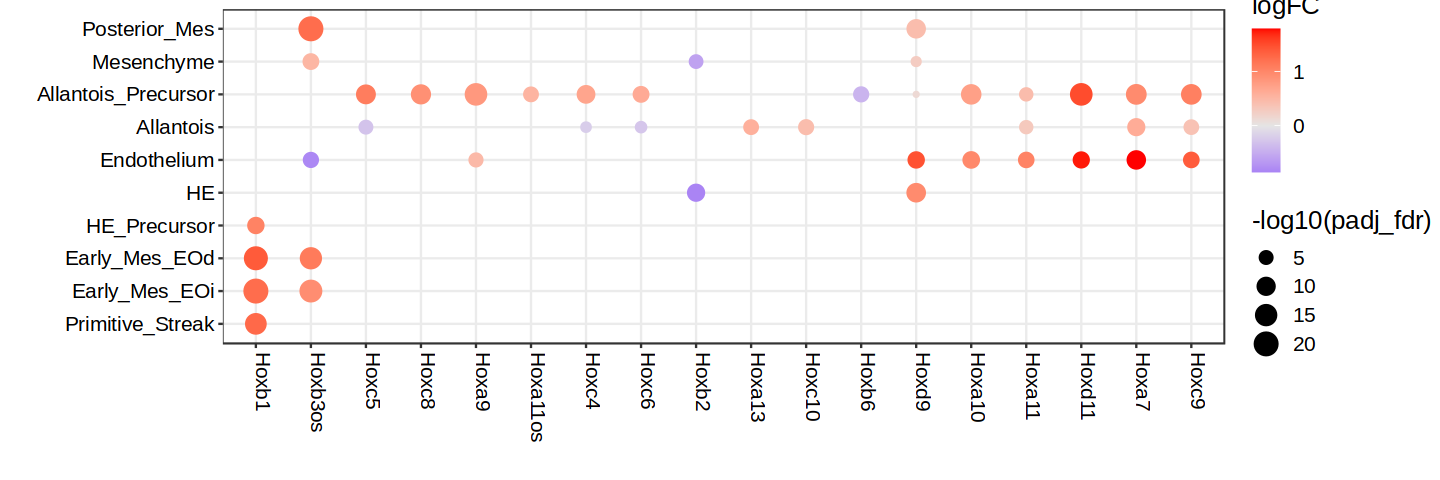

In [210]:
# all Hox genes
features = unique(DEGs$gene)[grep('^Hox', unique(DEGs$gene))]

# Turn dt in matrix
DEGs.mtx = DEGs[gene %in% features ,c('gene',  'logFC', 'celltype')] %>% dcast(., celltype ~ gene, value.var = 'logFC')
DEGs.mtx[is.na(DEGs.mtx)] = 0
DEGs.mtx = DEGs.mtx %>% as.data.frame() %>% tibble::column_to_rownames('celltype')

# Cluster genes by logFC
order = hclust(dist(t(DEGs.mtx)))

# prepare data.table for plotting
to.plot = DEGs[gene %in% features & padj_fdr < 0.05] %>%
    .[, gene := factor(gene, levels = order$labels[order$order])] %>%
    .[, celltype := factor(celltype, levels = opts$celltype_levels)]

options(repr.plot.width=12, repr.plot.height=4)
ggplot(to.plot, aes(gene, celltype, size=-log10(padj_fdr), col=logFC)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC') + 
    xlab('') + ylab('') + 
    theme_bw() + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0),
         axis.text=element_text(size=12, color='black'),
         text=element_text(size=15))

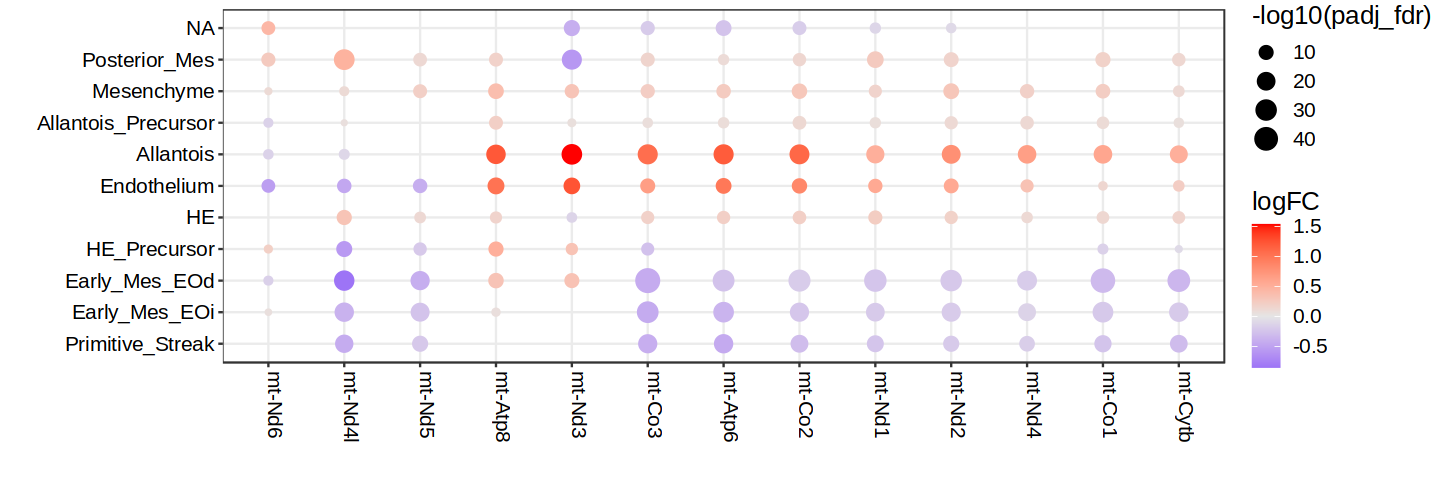

In [211]:
# all Hox genes
features = unique(DEGs$gene)[grep('^mt-', unique(DEGs$gene))]

# Turn dt in matrix
DEGs.mtx = DEGs[gene %in% features ,c('gene',  'logFC', 'celltype')] %>% dcast(., celltype ~ gene, value.var = 'logFC')
DEGs.mtx[is.na(DEGs.mtx)] = 0
DEGs.mtx = DEGs.mtx %>% as.data.frame() %>% tibble::column_to_rownames('celltype')

# Cluster genes by logFC
order = hclust(dist(t(DEGs.mtx)))

# prepare data.table for plotting
to.plot = DEGs[gene %in% features & padj_fdr < 0.05] %>%
    .[, gene := factor(gene, levels = order$labels[order$order])] %>%
    .[, celltype := factor(celltype, levels = opts$celltype_levels)]

options(repr.plot.width=12, repr.plot.height=4)
ggplot(to.plot[padj_fdr < 0.05], aes(gene, celltype, size=-log10(padj_fdr), col=logFC)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC') + 
    xlab('') + ylab('') + 
    theme_bw() + 
    theme(axis.text.x=element_text(angle=-90, hjust=0, vjust=0),
         axis.text=element_text(size=12, color='black'),
         text=element_text(size=15))

# Plot genes

Warning message:
“Groups with fewer than two data points have been dropped.”


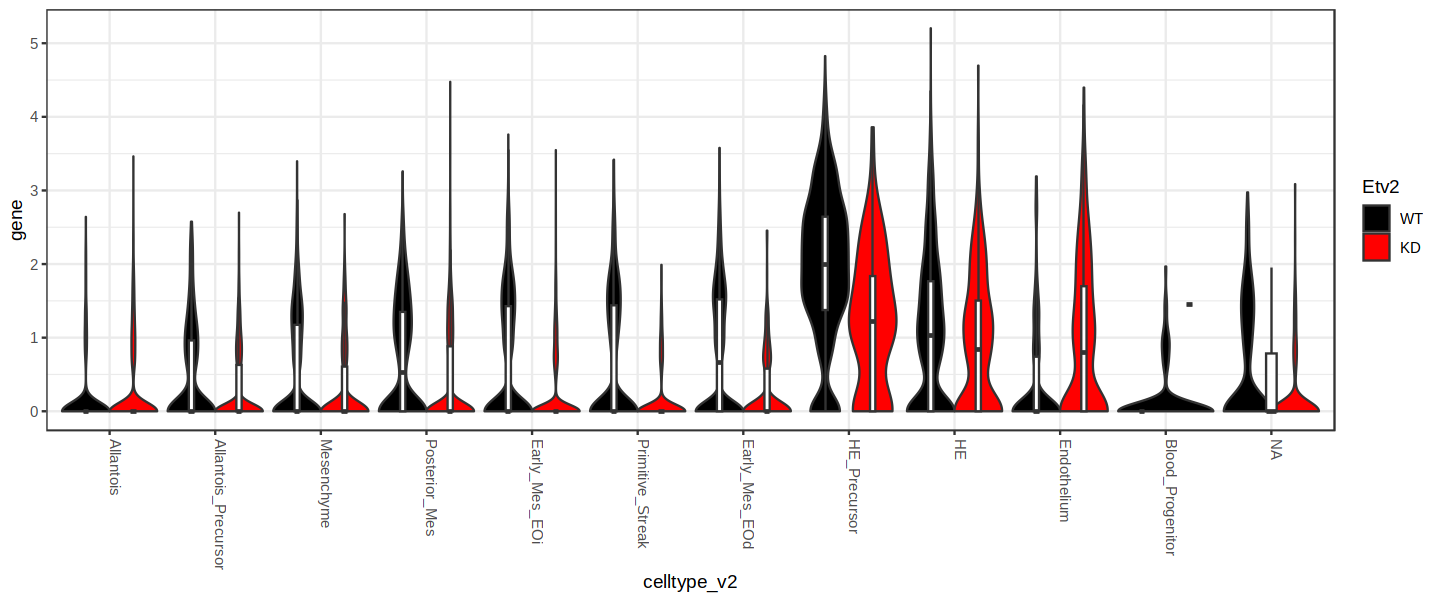

In [310]:
gene = 'Etv2'
meta = meta[match(colnames(rna.sce), cell)]
meta$gene = as.vector(logcounts(rna.sce[gene,]))
meta = meta[,genotype:=factor(gsub('KO', 'KD', genotype), levels=c('WT', 'KD'))] %>%
    .[order(gene)]

options(repr.plot.width=12, repr.plot.height=5)
ggplot(meta[, celltype_v2 := factor(celltype_v2, levels=names(opts$celltype_v2.colors))], aes(celltype_v2, gene, fill=genotype)) + 
    geom_violin(scale = 'width') +
    geom_boxplot(aes(group = interaction(genotype, celltype_v2)), fill = 'white', width = 0.1, position = position_dodge(0.9), outlier.shape = NA) + 
    scale_fill_manual(values=c(opts$genotype.colors, 'KD'= 'red'), name=gene) + 
   # facet_wrap(~genotype) + 
    theme_bw() + 
    theme(strip.text=element_text(size=25),
         axis.text.x = element_text(angle=-90, hjust=0, vjust=0))

Warning message:
“Groups with fewer than two data points have been dropped.”


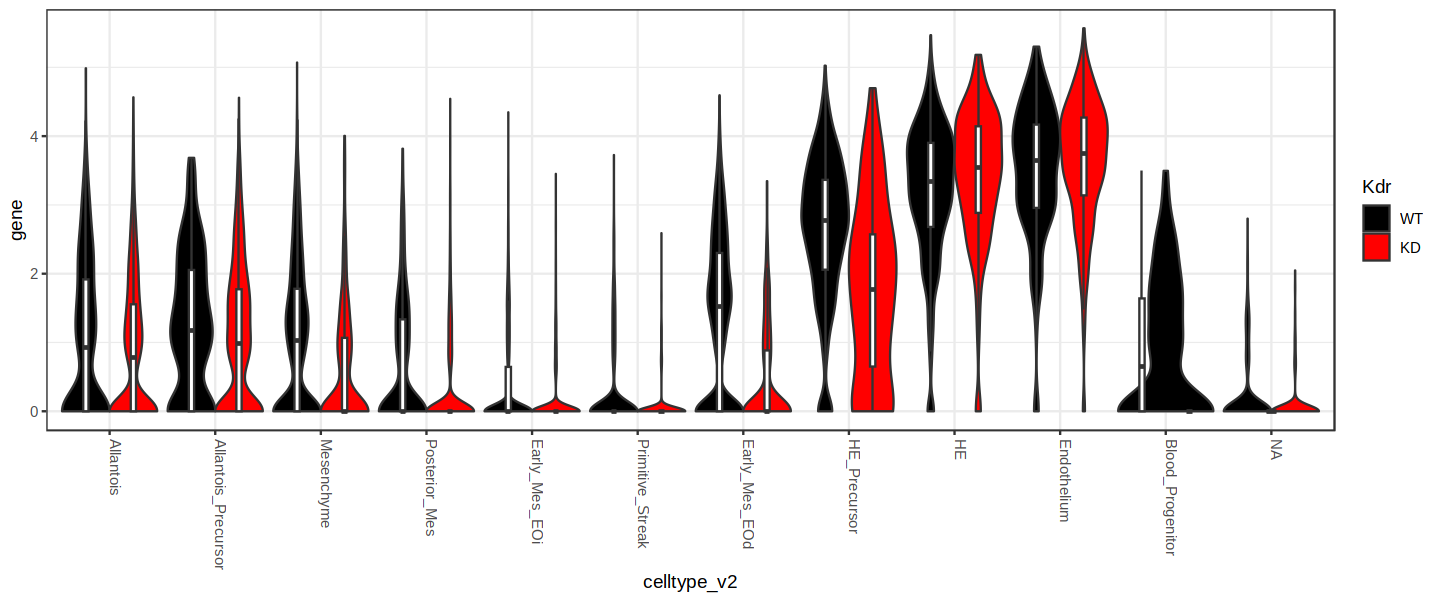

In [311]:
gene = 'Kdr'
meta = meta[match(colnames(rna.sce), cell)]
meta$gene = as.vector(logcounts(rna.sce[gene,]))
meta = meta[,genotype:=factor(gsub('KO', 'KD', genotype), levels=c('WT', 'KD'))] %>%
    .[order(gene)]

options(repr.plot.width=12, repr.plot.height=5)
ggplot(meta[, celltype_v2 := factor(celltype_v2, levels=names(opts$celltype_v2.colors))], aes(celltype_v2, gene, fill=genotype)) + 
    geom_violin(scale = 'width') +
    geom_boxplot(aes(group = interaction(genotype, celltype_v2)), fill = 'white', width = 0.1, position = position_dodge(0.9), outlier.shape = NA) + 
    scale_fill_manual(values=c(opts$genotype.colors, 'KD'= 'red'), name=gene) + 
   # facet_wrap(~genotype) + 
    theme_bw() + 
    theme(strip.text=element_text(size=25),
         axis.text.x = element_text(angle=-90, hjust=0, vjust=0))

In [318]:
rna.sce

class: SingleCellExperiment 
dim: 32285 27135 
metadata(0):
assays(2): counts logcounts
rownames(32285): Xkr4 Gm1992 ... AC234645.1 AC149090.1
rowData names(0):
colnames(27135): 2_Eo_DEG_G9_day3_5_VC#AAACAGCCAAAGCGGC-1
  2_Eo_DEG_G9_day3_5_VC#AAACAGCCAACCTAAT-1 ...
  rv_eo_deg_day4_dtag#TTTGTGTTCATTTGTC-1
  rv_eo_deg_day4_dtag#TTTGTTGGTACTTAGG-1
colData names(27): barcode sample ... celltype_v1 celltype_v2
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

Warning message:
“Groups with fewer than two data points have been dropped.”


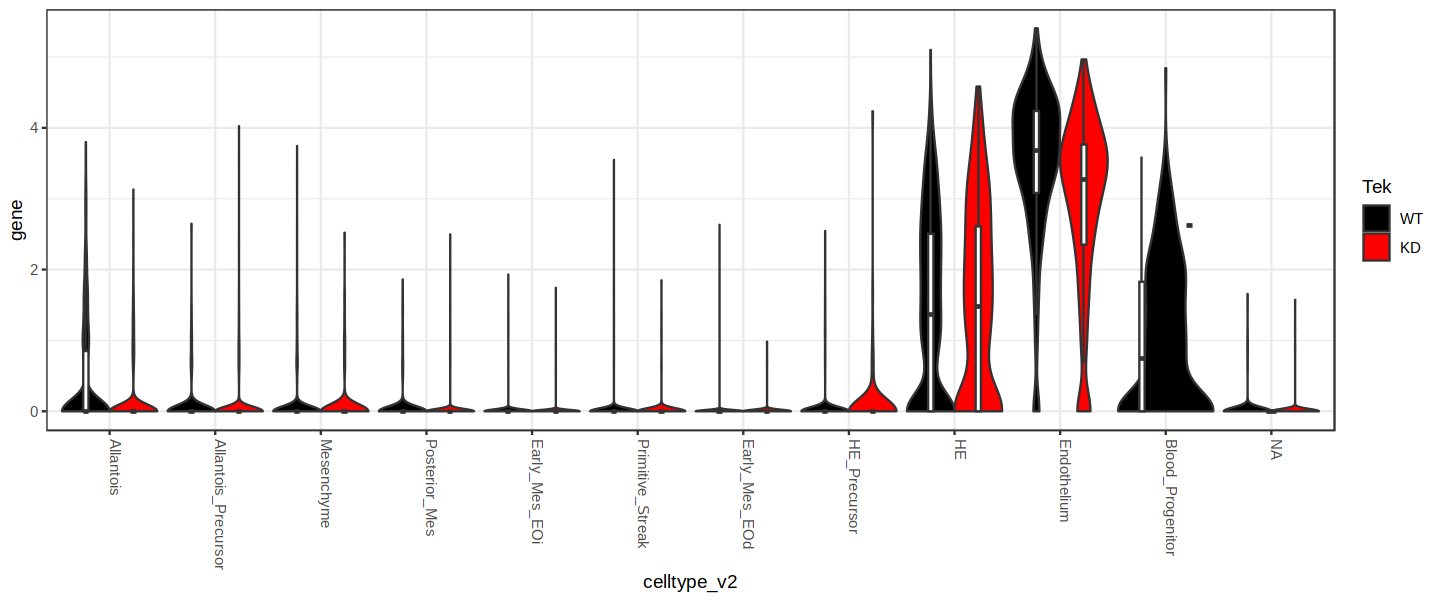

In [320]:
gene = 'Tek'
meta = meta[match(colnames(rna.sce), cell)]
meta$gene = as.vector(logcounts(rna.sce[gene,]))
meta = meta[,genotype:=factor(gsub('KO', 'KD', genotype), levels=c('WT', 'KD'))] %>%
    .[order(gene)]

options(repr.plot.width=12, repr.plot.height=5)
ggplot(meta[, celltype_v2 := factor(celltype_v2, levels=names(opts$celltype_v2.colors))], aes(celltype_v2, gene, fill=genotype)) + 
    geom_violin(scale = 'width') +
    geom_boxplot(aes(group = interaction(genotype, celltype_v2)), fill = 'white', width = 0.1, position = position_dodge(0.9), outlier.shape = NA) + 
    scale_fill_manual(values=c(opts$genotype.colors, 'KD'= 'red'), name=gene) + 
   # facet_wrap(~genotype) + 
    theme_bw() + 
    theme(strip.text=element_text(size=25),
         axis.text.x = element_text(angle=-90, hjust=0, vjust=0))

Warning message:
“Groups with fewer than two data points have been dropped.”


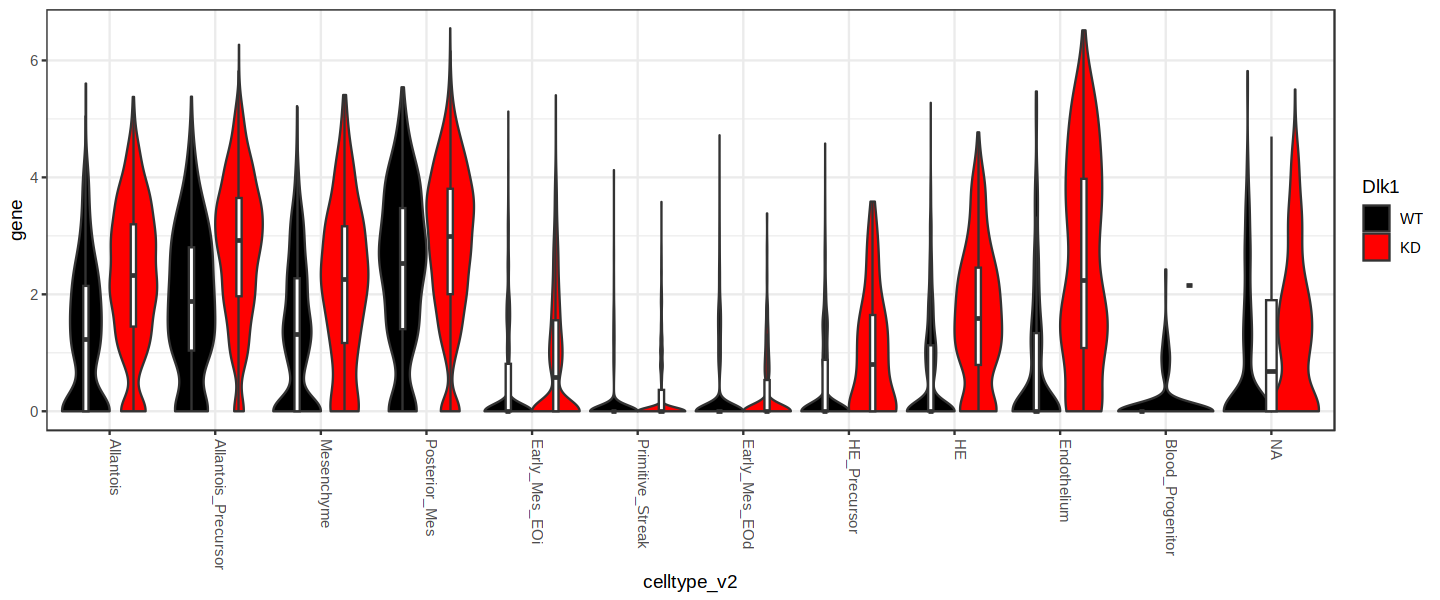

In [328]:
gene = 'Dlk1'
meta = meta[match(colnames(rna.sce), cell)]
meta$gene = as.vector(logcounts(rna.sce[gene,]))
meta = meta[,genotype:=factor(gsub('KO', 'KD', genotype), levels=c('WT', 'KD'))] %>%
    .[order(gene)]

options(repr.plot.width=12, repr.plot.height=5)
ggplot(meta[, celltype_v2 := factor(celltype_v2, levels=names(opts$celltype_v2.colors))], aes(celltype_v2, gene, fill=genotype)) + 
    geom_violin(scale = 'width') +
    geom_boxplot(aes(group = interaction(genotype, celltype_v2)), fill = 'white', width = 0.1, position = position_dodge(0.9), outlier.shape = NA) + 
    scale_fill_manual(values=c(opts$genotype.colors, 'KD'= 'red'), name=gene) + 
   # facet_wrap(~genotype) + 
    theme_bw() + 
    theme(strip.text=element_text(size=25),
         axis.text.x = element_text(angle=-90, hjust=0, vjust=0))

Warning message:
“Groups with fewer than two data points have been dropped.”


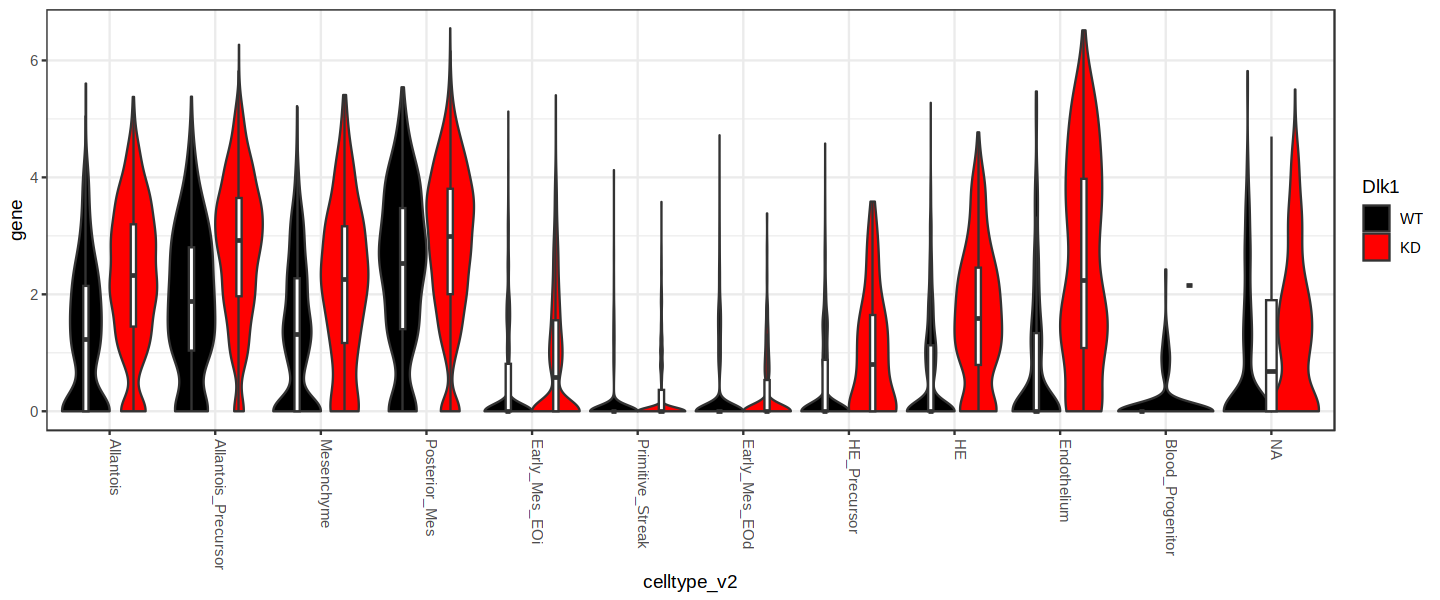

In [328]:
gene = 'Dlk1'
meta = meta[match(colnames(rna.sce), cell)]
meta$gene = as.vector(logcounts(rna.sce[gene,]))
meta = meta[,genotype:=factor(gsub('KO', 'KD', genotype), levels=c('WT', 'KD'))] %>%
    .[order(gene)]

options(repr.plot.width=12, repr.plot.height=5)
ggplot(meta[, celltype_v2 := factor(celltype_v2, levels=names(opts$celltype_v2.colors))], aes(celltype_v2, gene, fill=genotype)) + 
    geom_violin(scale = 'width') +
    geom_boxplot(aes(group = interaction(genotype, celltype_v2)), fill = 'white', width = 0.1, position = position_dodge(0.9), outlier.shape = NA) + 
    scale_fill_manual(values=c(opts$genotype.colors, 'KD'= 'red'), name=gene) + 
   # facet_wrap(~genotype) + 
    theme_bw() + 
    theme(strip.text=element_text(size=25),
         axis.text.x = element_text(angle=-90, hjust=0, vjust=0))

In [30]:
meta = fread(args$metadata)[day!='D3']

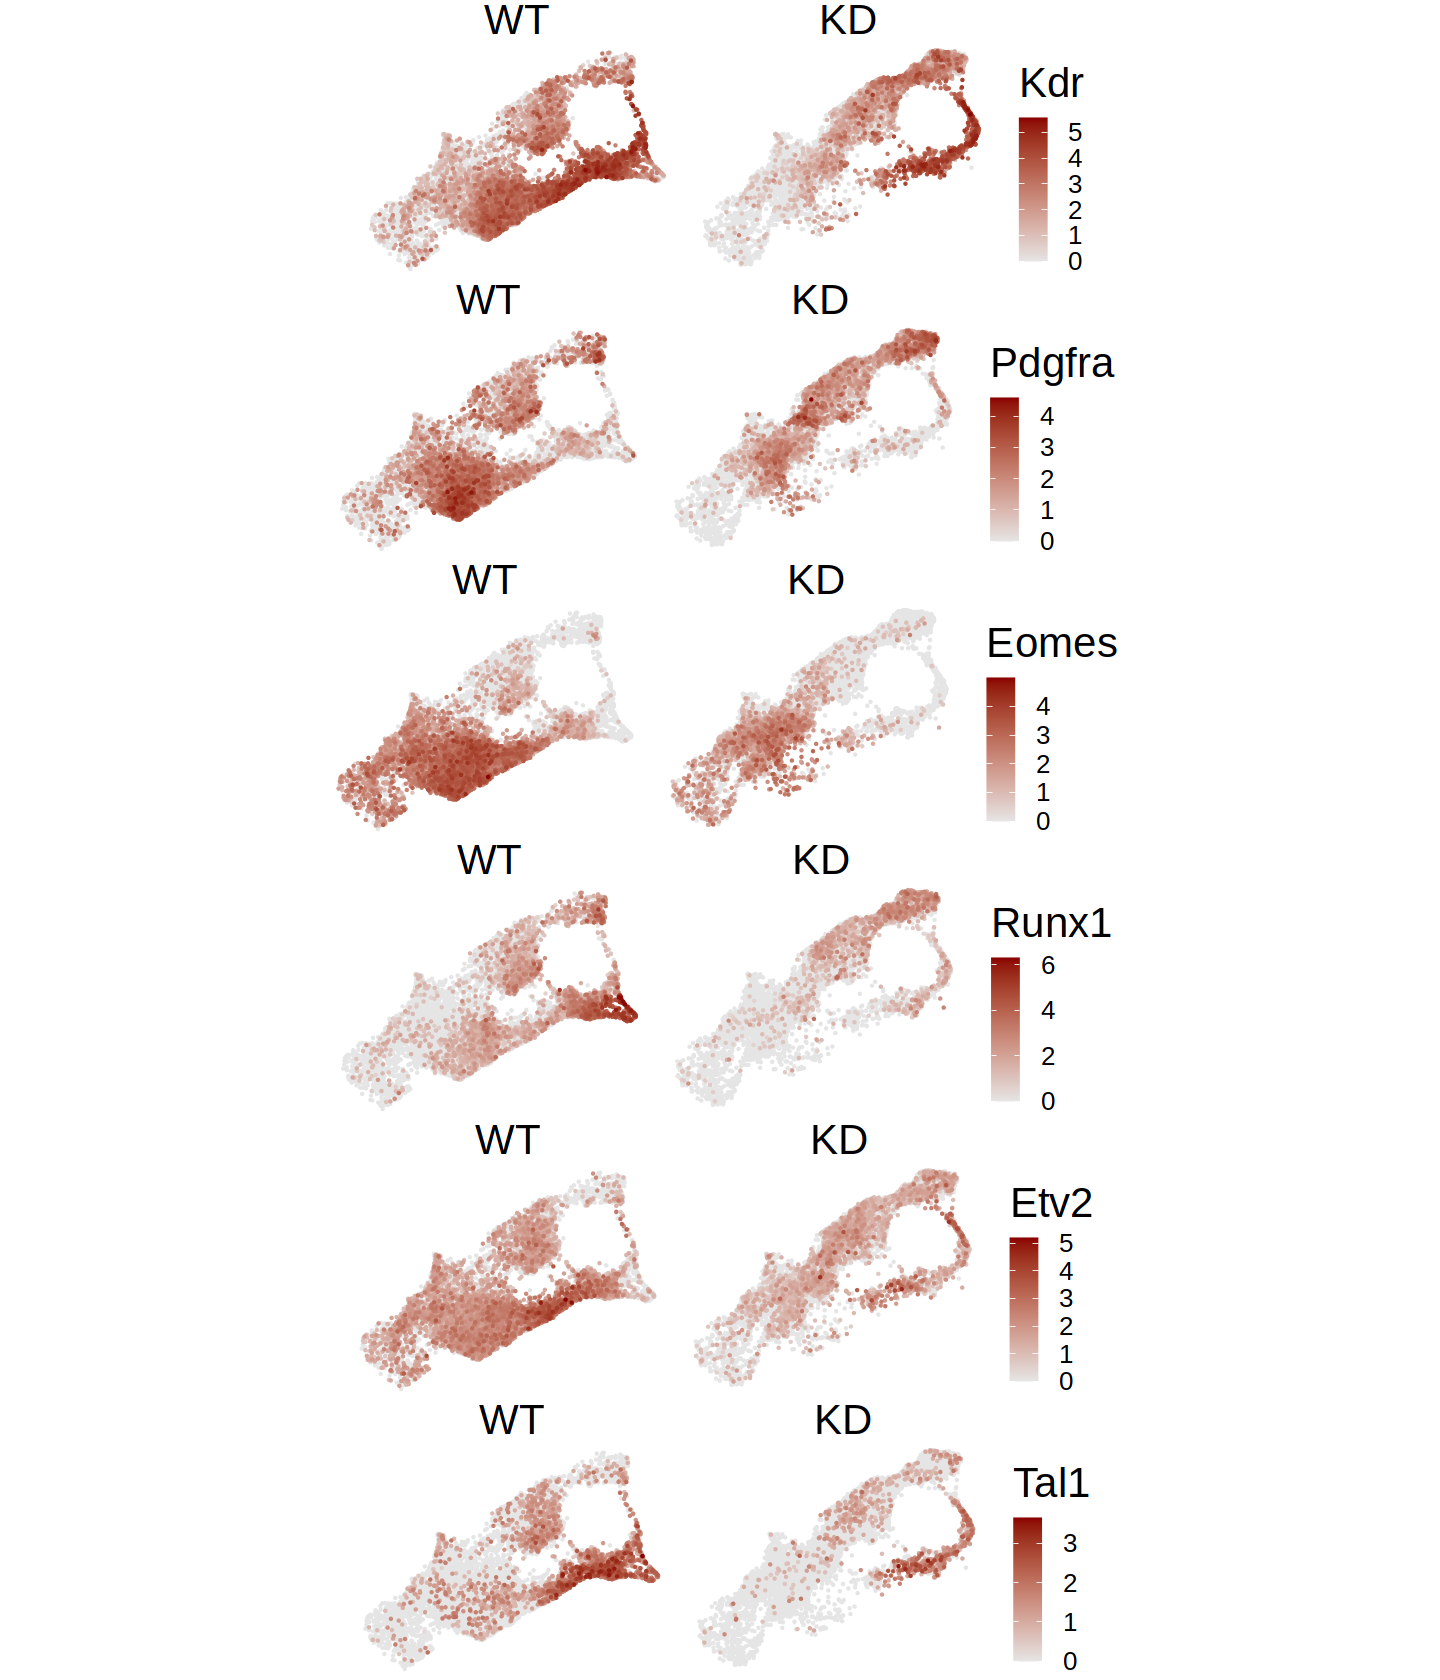

In [53]:
options(repr.plot.width=12, repr.plot.height=14)

plot_gene_umap = function(gene){
    # meta = meta[match(colnames(rna.sce), cell)]
    meta$gene = as.vector(logcounts(rna.sce[gene, meta$cell]))
    meta = meta[,genotype:=factor(gsub('KO', 'KD', genotype), levels=c('WT', 'KD'))] %>%
        .[order(gene)]

    #options(repr.plot.width=9, repr.plot.height=10)
    ggplot(meta, aes(UMAP1, UMAP2, color = gene)) + 
        geom_point(size = 0.2) + 
        scale_color_gradient2(low = 'blue', mid = 'grey90', high = 'darkred', name = gene) + 
        facet_wrap(~genotype) + 
        coord_fixed() + 
        theme_void() + 
        theme(strip.text = element_text(size = 25),
              legend.title = element_text(size = 25, hjust = 0, vjust = 0),
              legend.text = element_text(size = 15))
}

genes = c('Kdr', 'Pdgfra', 'Eomes', 'Runx1', 'Etv2', 'Tal1')
ggarrange(plotlist = lapply(genes, plot_gene_umap), ncol = 1)